Nama    : Muhamad Fahrurrozi

Project Home Credit

https://github.com/fahru-razi

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
import igraph as ig
import lightgbm as lgb

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve

In [4]:
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
previous_application = pd.read_csv('previous_application.csv')

## Marge Data

In [5]:
# Menggabungkan data train
bureau_agg = bureau.groupby('SK_ID_CURR').mean()
previous_application_agg = previous_application.groupby('SK_ID_CURR').mean()

merged_data_train = pd.merge(application_train, bureau_agg, how='left', on='SK_ID_CURR', suffixes=('_app', '_bur'))
merged_data_train = pd.merge(merged_data_train, previous_application_agg, how='left', on='SK_ID_CURR', suffixes=('', '_prev'))

C:\Users\USER\AppData\Local\Temp\ipykernel_16668\3303193528.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bureau_agg = bureau.groupby('SK_ID_CURR').mean()
C:\Users\USER\AppData\Local\Temp\ipykernel_16668\3303193528.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  previous_application_agg = previous_application.groupby('SK_ID_CURR').mean()


In [6]:
# Menyimpan hasil penggabungan ke file baru
merged_data_train.to_csv('merged_train.csv', index=False)

In [7]:
data_train = pd.read_csv('merged_train.csv')

In [8]:
data_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0               Y             0          202500.0    406597.5   
1               N             0          270000.0   1293502.5   
2               Y             0           67500.0    135000.0   
3               Y             0          135000.0    312682.5   
4               Y             0          121500.0    513000.0   

   AMT_ANNUITY_app  ...  RATE_INTEREST_PRIVILEGED DAYS_DECISION  \
0          24700.5  ...                       NaN   -606.000000   
1          35698.5  ...                       NaN  -1305.000000   
2           6750.0  ...                       NaN   -815.000000   
3          29686.5  ...                       NaN   -272.444444   
4          21865.5  ...                       NaN  -1222.833333   

  SELLERPLACE_AREA CNT_PAYMENT DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
0       500.000000   24.000000           365243.0    -565.000000   
1       533.000000   10.000000           365243.0   -1274.333333   
2        30.000000    4.000000           365243.0    -784.000000   
3       894.222222   23.000000           365243.0   91066.500000   
4       409.166667   20.666667           365243.0   -1263.200000   

   DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0                 125.000000     -25.000000        -17.000000   
1               -1004.333333   -1054.333333      -1047.333333   
2                -694.000000    -724.000000       -714.000000   
3               91584.000000  182477.500000     182481.750000   
4                -837.200000   72136.200000      72143.800000   

   NFLAG_INSURED_ON_APPROVAL  
0                   0.000000  
1                   0.666667  
2                   0.000000  
3                   0.000000  
4                   0.600000  

[5 rows x 155 columns]

# Data Pre-Proccesing Data Mining

In [9]:
# Setting tampilan
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

In [10]:
data_train['TARGET'] = data_train['TARGET'].replace({0: 1, 1: 0})

In [11]:
data_train.duplicated().sum()

0

In [12]:
# Menghapus kolom SK_ID_CURR
data_train = data_train.drop(columns=['SK_ID_CURR'])

In [13]:
# Identifikasi dan Filtrasi Kolom dengan Lebih dari 50% Data Null
missing_values = data_train.isnull().mean()
missing_values[missing_values>0.5]

OWN_CAR_AGE                 0.659908
EXT_SOURCE_1                0.563811
APARTMENTS_AVG              0.507497
BASEMENTAREA_AVG            0.585160
YEARS_BUILD_AVG             0.664978
COMMONAREA_AVG              0.698723
ELEVATORS_AVG               0.532960
ENTRANCES_AVG               0.503488
FLOORSMIN_AVG               0.678486
LANDAREA_AVG                0.593767
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAREA_AVG              0.501933
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAREA_AVG           0.551792
APARTMENTS_MODE             0.507497
BASEMENTAREA_MODE           0.585160
YEARS_BUILD_MODE            0.664978
COMMONAREA_MODE             0.698723
ELEVATORS_MODE              0.532960
ENTRANCES_MODE              0.503488
FLOORSMIN_MODE              0.678486
LANDAREA_MODE               0.593767
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAREA_MODE             0.501933
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAREA_MODE          0.551792
APARTMENTS_MEDI             0.507497
B

In [14]:
# Menghapus kolom dengan tingkat missing value > 50%
threshold = 0.5
data_train_cleaned = data_train.dropna(thresh=data_train.shape[0] * (1 - threshold), axis=1)

In [15]:
data_train_cleaned.shape

(307511, 110)

In [16]:
categorical_columns = data_train_cleaned.select_dtypes(include=['object']).columns

data_encoded = pd.get_dummies(data_train_cleaned, columns=categorical_columns)

In [17]:
numerical_columns = data_encoded.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_columns:
    median = data_encoded[col].median()
    data_encoded[col] = (data_encoded[col] > median).astype(int)

# Bussines Insight

## EDA (Exploratory Data Analysis)

In [18]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 154 entries, TARGET to NFLAG_INSURED_ON_APPROVAL
dtypes: float64(98), int64(40), object(16)
memory usage: 361.3+ MB


In [19]:
kategorikal_cols = data_train.select_dtypes(include=['object']).columns
numerikal_cols = data_train.select_dtypes(exclude=['object']).columns

print("Kolom Kategorikal:")
print(kategorikal_cols)

print("\nKolom Numerik:")
print(numerikal_cols)

jumlah_kategorikal_cols = len(kategorikal_cols)
jumlah_numerikal_cols = len(numerikal_cols)

print("\nJumlah Kolom Kategorikal:", jumlah_kategorikal_cols)
print("Jumlah Kolom Numerik:", jumlah_numerikal_cols)

Kolom Kategorikal:
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'], dtype='object')

Kolom Numerik:
Index(['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY_app', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'], dtype='object', length=138)

Jumlah Kolom Kategorikal: 16
Jumlah Kolom Numerik: 138


In [20]:
corr_matrix = data_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
cols_drop = [(column, row) for column in upper.columns for row in upper.index if upper.loc[row, column] > 0.7]

for pair in cols_drop:
    print(pair)

C:\Users\USER\AppData\Local\Temp\ipykernel_16668\1921038827.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_train.corr().abs()


('AMT_ANNUITY_app', 'AMT_CREDIT')
('AMT_GOODS_PRICE', 'AMT_CREDIT')
('AMT_GOODS_PRICE', 'AMT_ANNUITY_app')
('FLAG_EMP_PHONE', 'DAYS_EMPLOYED')
('CNT_FAM_MEMBERS', 'CNT_CHILDREN')
('REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT')
('LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_WORK_REGION')
('LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY')
('ELEVATORS_AVG', 'APARTMENTS_AVG')
('FLOORSMIN_AVG', 'FLOORSMAX_AVG')
('LIVINGAPARTMENTS_AVG', 'APARTMENTS_AVG')
('LIVINGAPARTMENTS_AVG', 'ELEVATORS_AVG')
('LIVINGAREA_AVG', 'APARTMENTS_AVG')
('LIVINGAREA_AVG', 'ELEVATORS_AVG')
('LIVINGAREA_AVG', 'LIVINGAPARTMENTS_AVG')
('APARTMENTS_MODE', 'APARTMENTS_AVG')
('APARTMENTS_MODE', 'ELEVATORS_AVG')
('APARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG')
('APARTMENTS_MODE', 'LIVINGAREA_AVG')
('BASEMENTAREA_MODE', 'BASEMENTAREA_AVG')
('YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG')
('YEARS_BUILD_MODE', 'YEARS_BUILD_AVG')
('COMMONAREA_MODE', 'COMMONAREA_AVG')
('ELEVATORS_MODE', 'APARTMENTS_AVG')

In [21]:
corr_matrix = data_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.7)]

df_train = data_train.drop(to_drop, axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_16668\4276412889.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_train.corr().abs()


C:\Users\USER\AppData\Local\Temp\ipykernel_16668\1524013106.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df_train.corr().fillna(0), dtype=np.bool_)
C:\Users\USER\AppData\Local\Temp\ipykernel_16668\1524013106.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)


<Axes: >

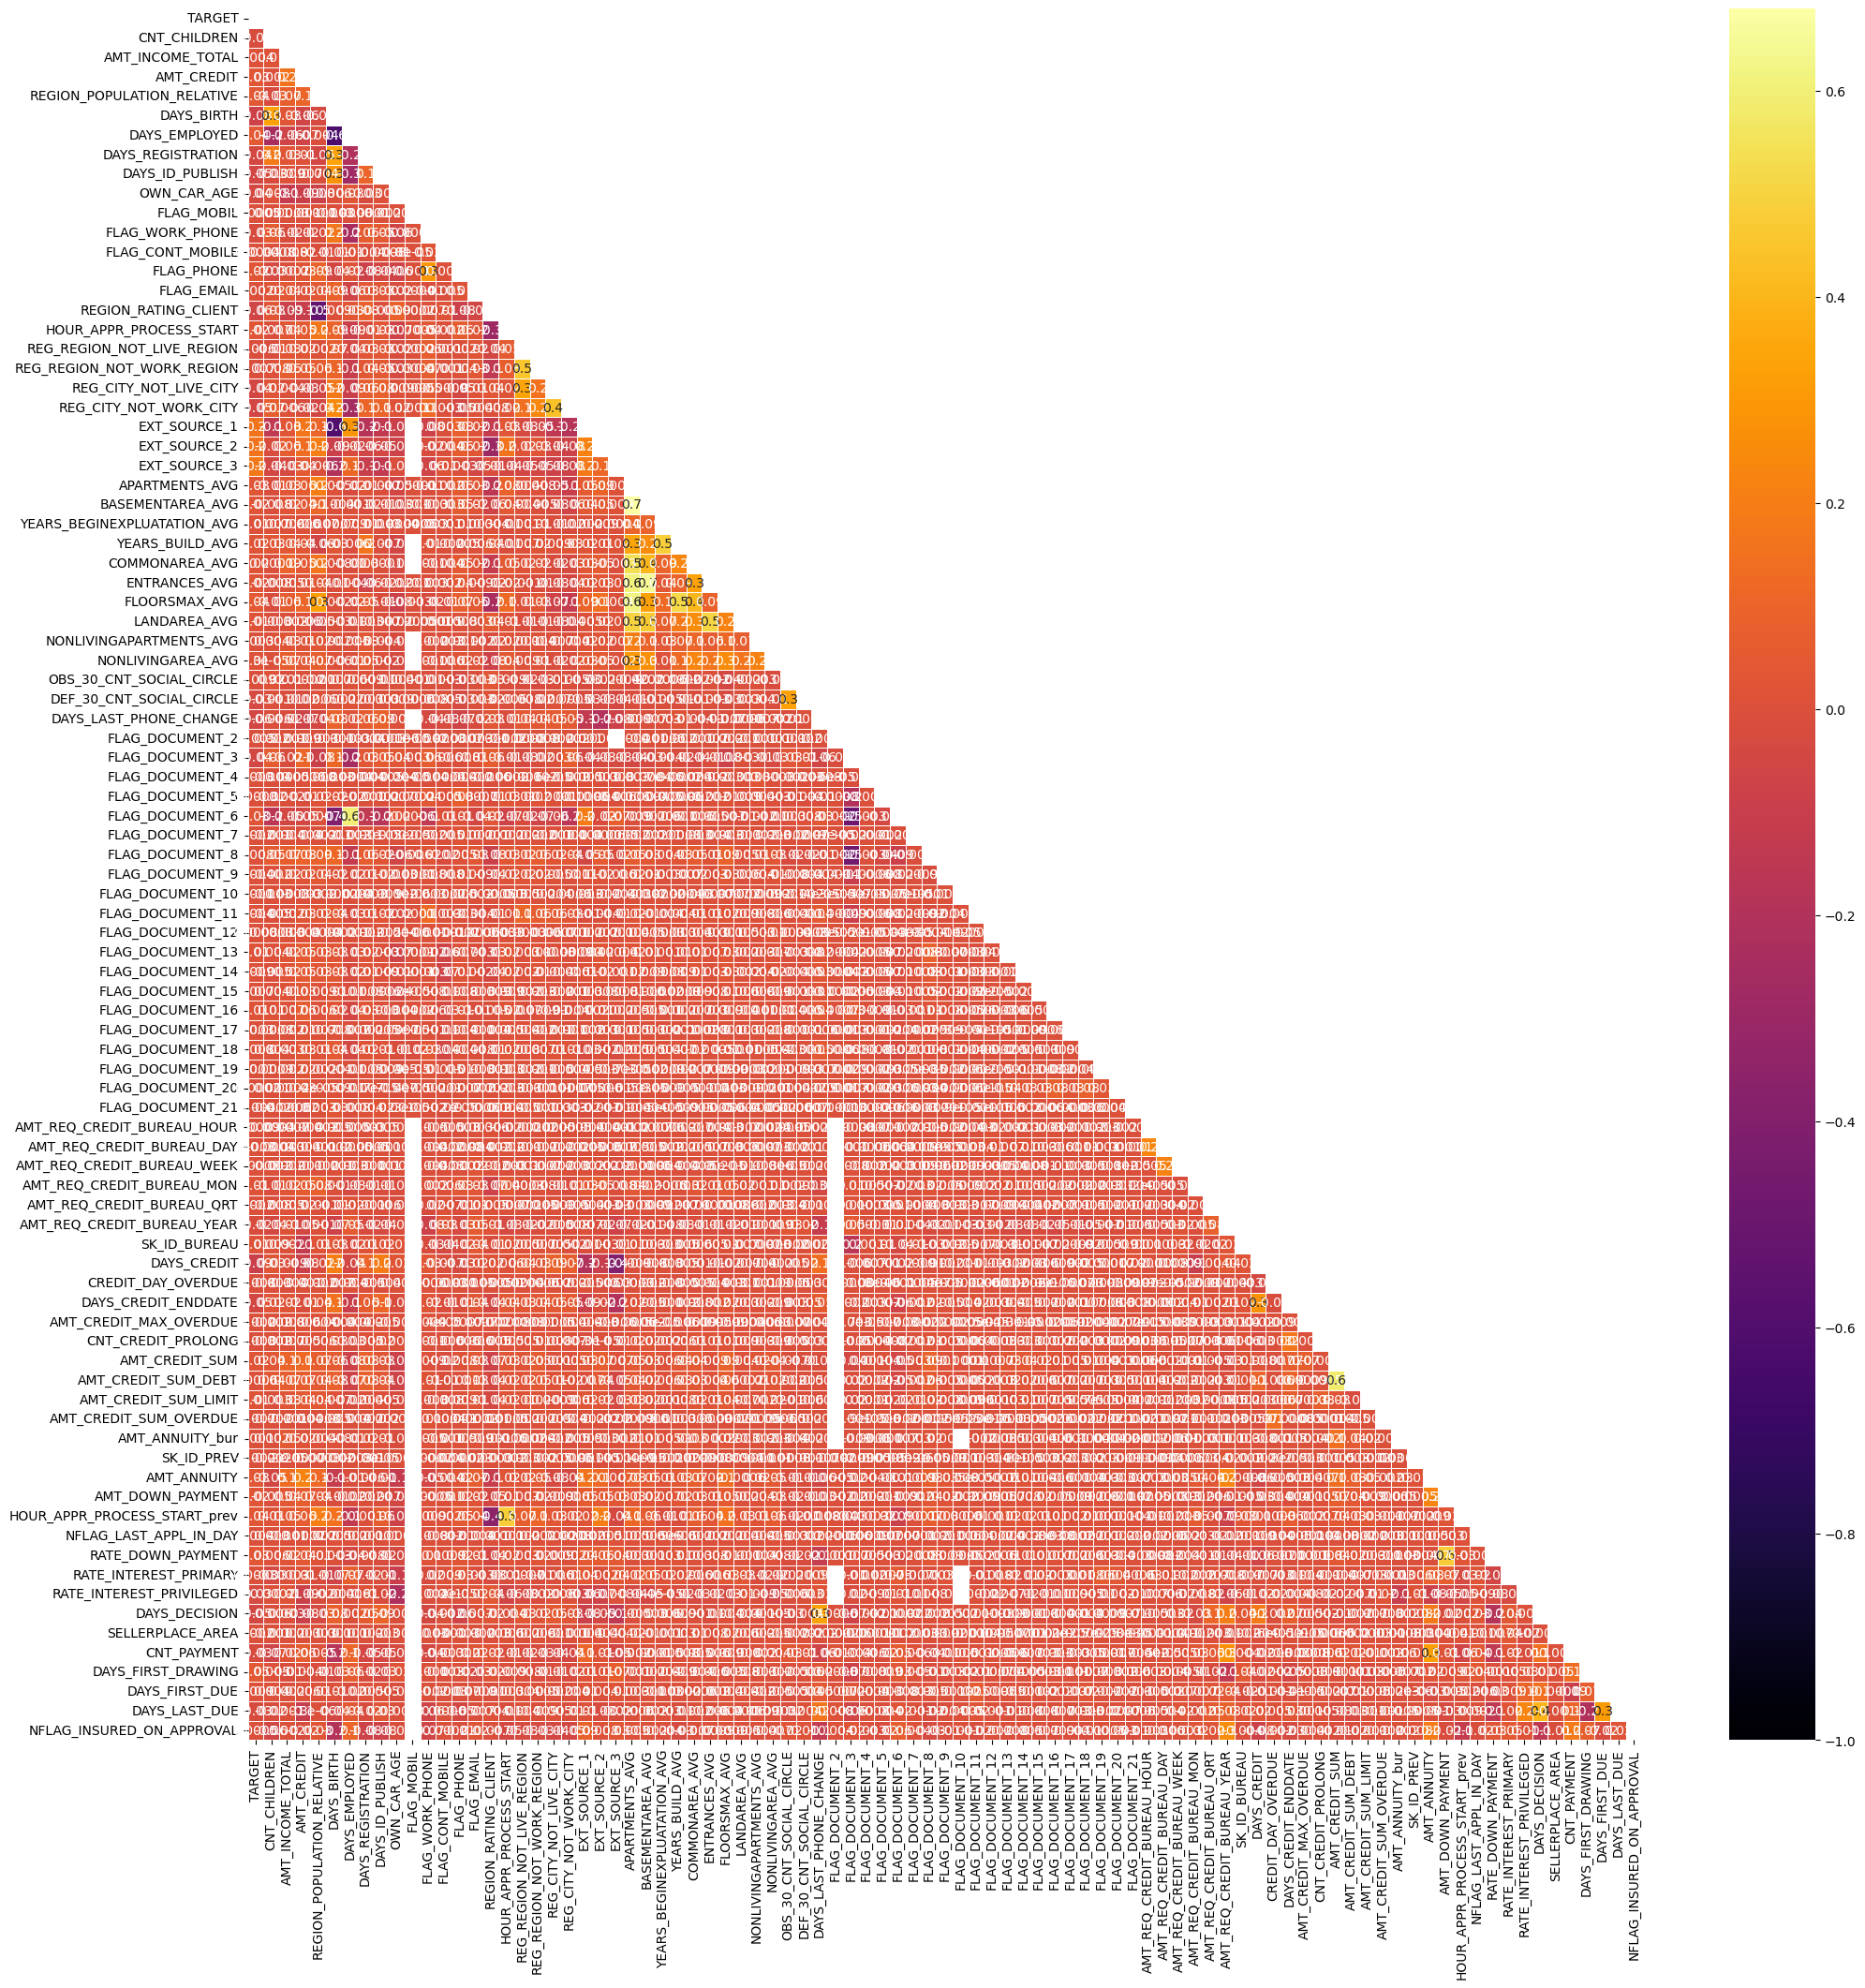

In [22]:
# Visualisasi Korelasi Matriks
mask = np.zeros_like(df_train.corr().fillna(0), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(df_train.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

In [23]:
# Distribusi Target pada dataset
counts = df_train['TARGET'].value_counts()

fig = go.Figure(data=[go.Pie(labels=counts.index,
                            values=counts.values,
                            hole=.3,
                            textinfo='label+percent',
                            insidetextorientation='radial'
                            )
                    ]
                )


fig.update_layout(
    title_text="Distribusi Home Credit",
    title_x=0.5,  
    title_y=0.95,  
    annotations=[dict(text='TARGET', x=0.5, y=0.5, font_size=20, showarrow=False)],
    width=800,  
    height=500,  
    margin=dict(t=50), 
)

fig.update_traces(marker=dict(line=dict(color='white', width=2)))

fig.update_layout(
    paper_bgcolor="lightgray",  
    showlegend=False 
)

fig.show()

C:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Univariate Analysis & Multivariate Analysis

In [24]:
categorical_cols = df_train.select_dtypes(include=['object']).columns
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

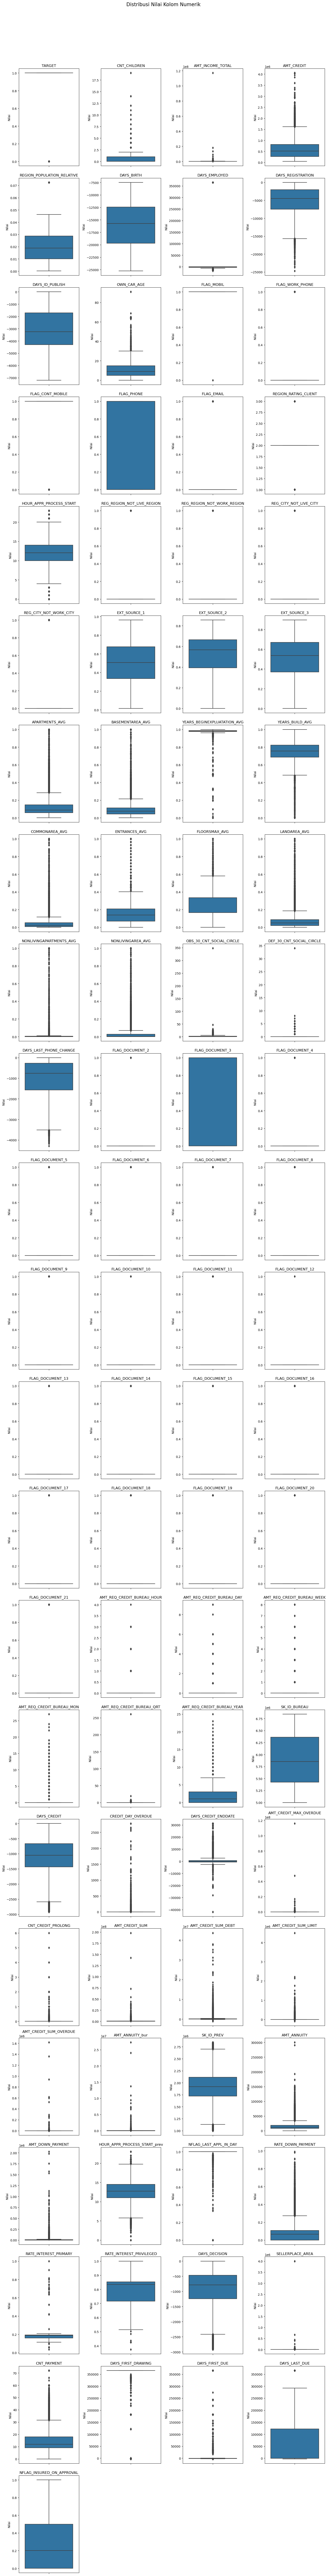

In [25]:
features_nums = numerical_cols

n = len(features_nums)
ncols = 4 
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5))

for i, feature in enumerate(features_nums):
    r = i // ncols
    c = i % ncols
    ax = axs[r, c]
    sns.boxplot(y=data_train[feature], ax=ax)
    ax.set_title(feature)
    ax.set_ylabel('Nilai')

if n % ncols != 0:
    for j in range(n, nrows*ncols):
        fig.delaxes(axs.flatten()[j])

plt.suptitle('Distribusi Nilai Kolom Numerik', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

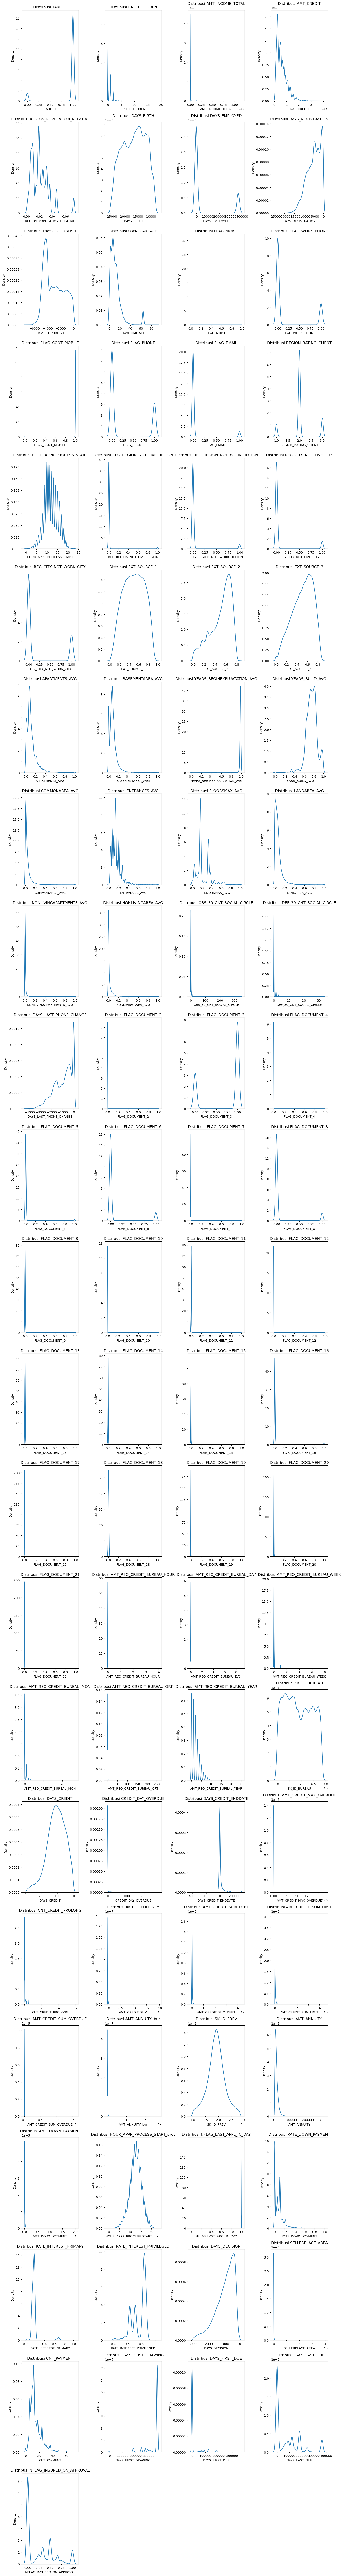

In [26]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*5))

for i, feature in enumerate(features_nums):
    r = i // ncols
    c = i % ncols
    ax = axs[r, c]
    sns.kdeplot(x=data_train[feature], ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribusi {feature}') 

if n % ncols != 0:
    for j in range(n, nrows*ncols):
        fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

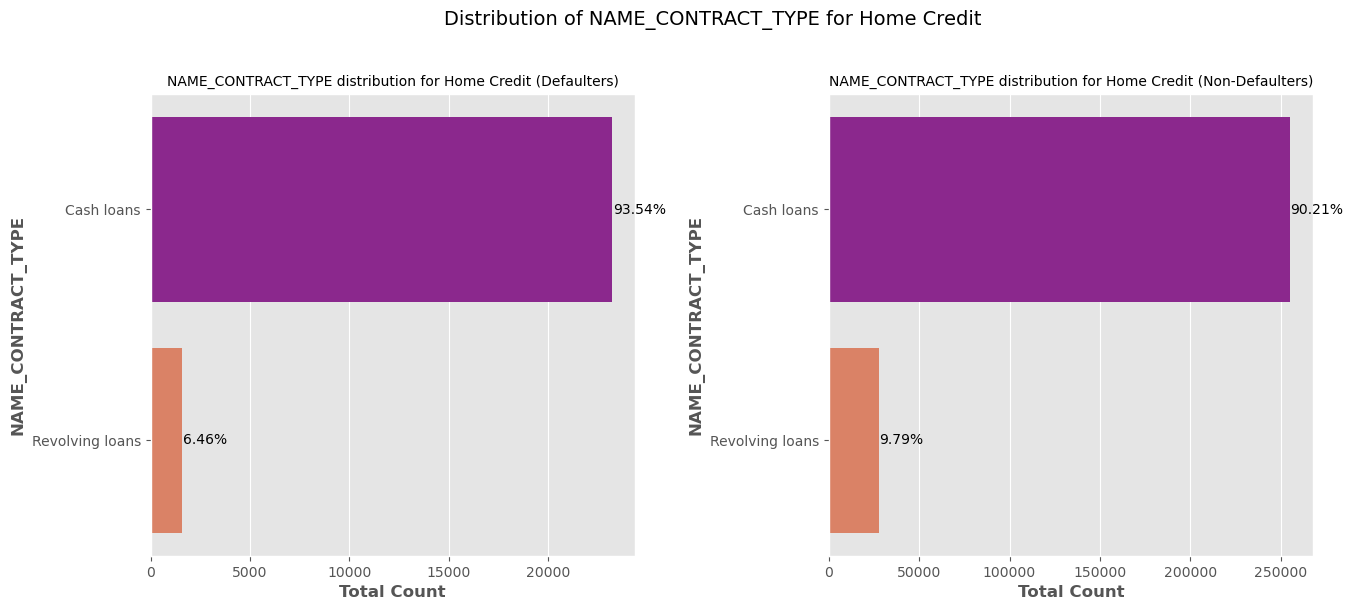

<Figure size 640x480 with 0 Axes>

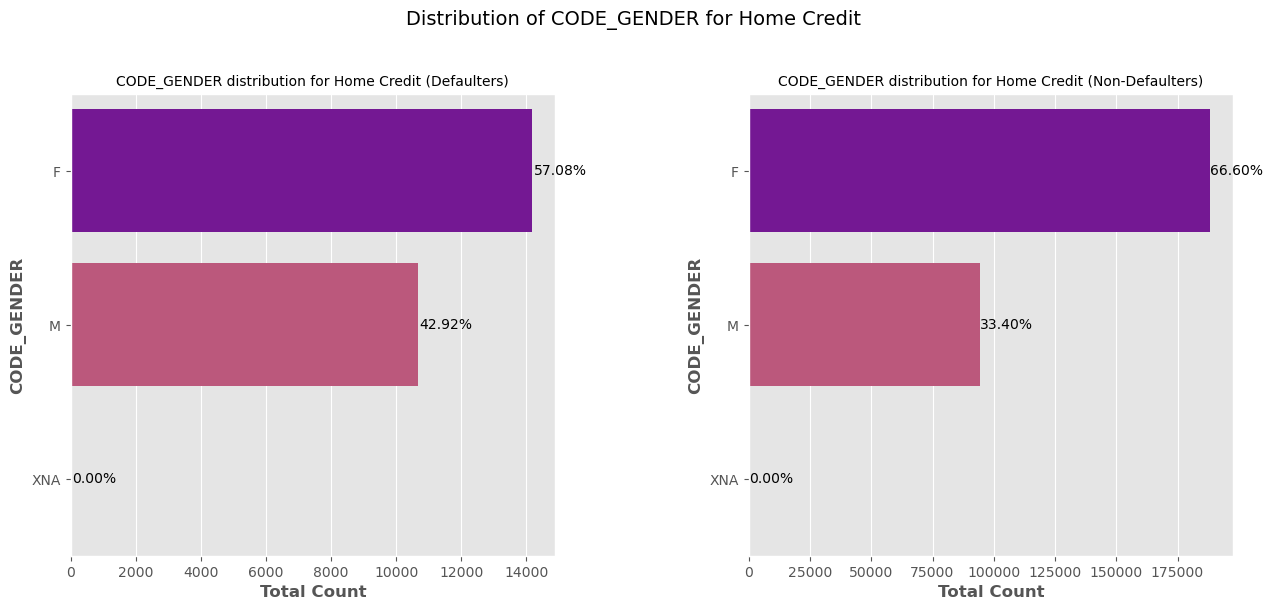

<Figure size 640x480 with 0 Axes>

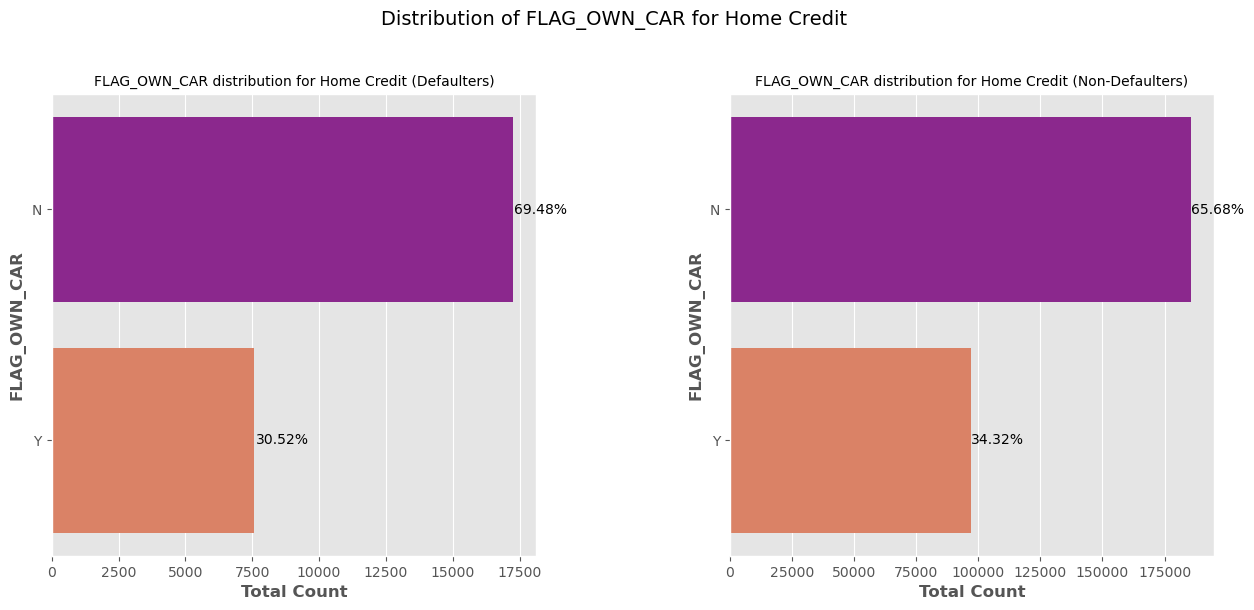

<Figure size 640x480 with 0 Axes>

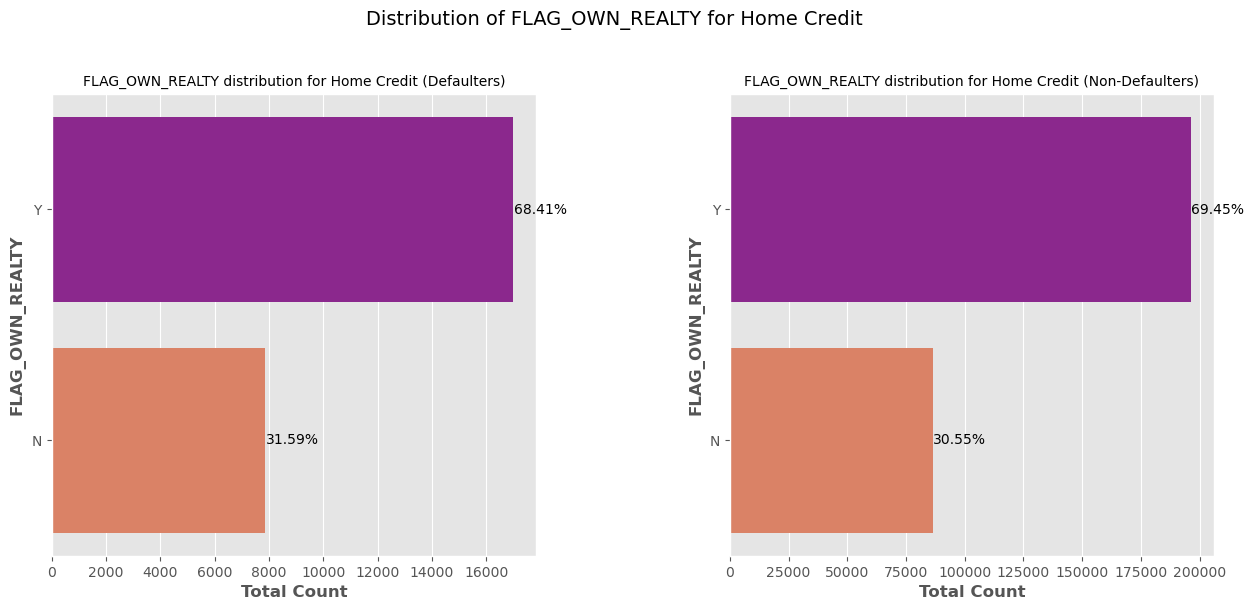

<Figure size 640x480 with 0 Axes>

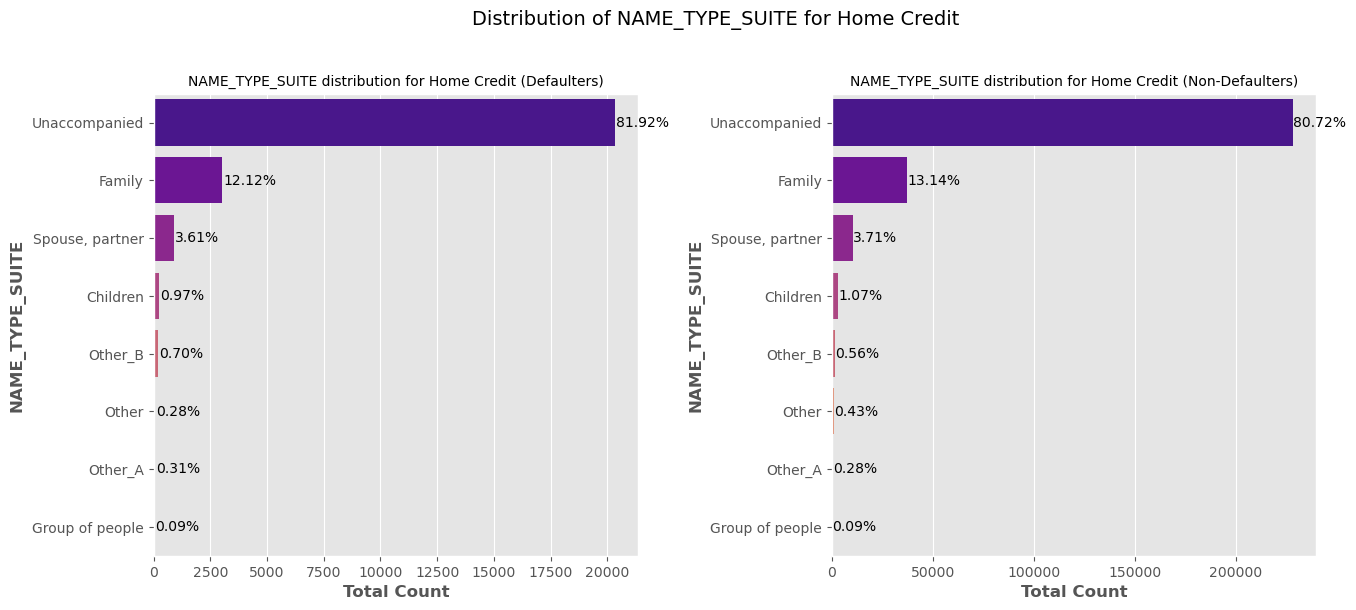

<Figure size 640x480 with 0 Axes>

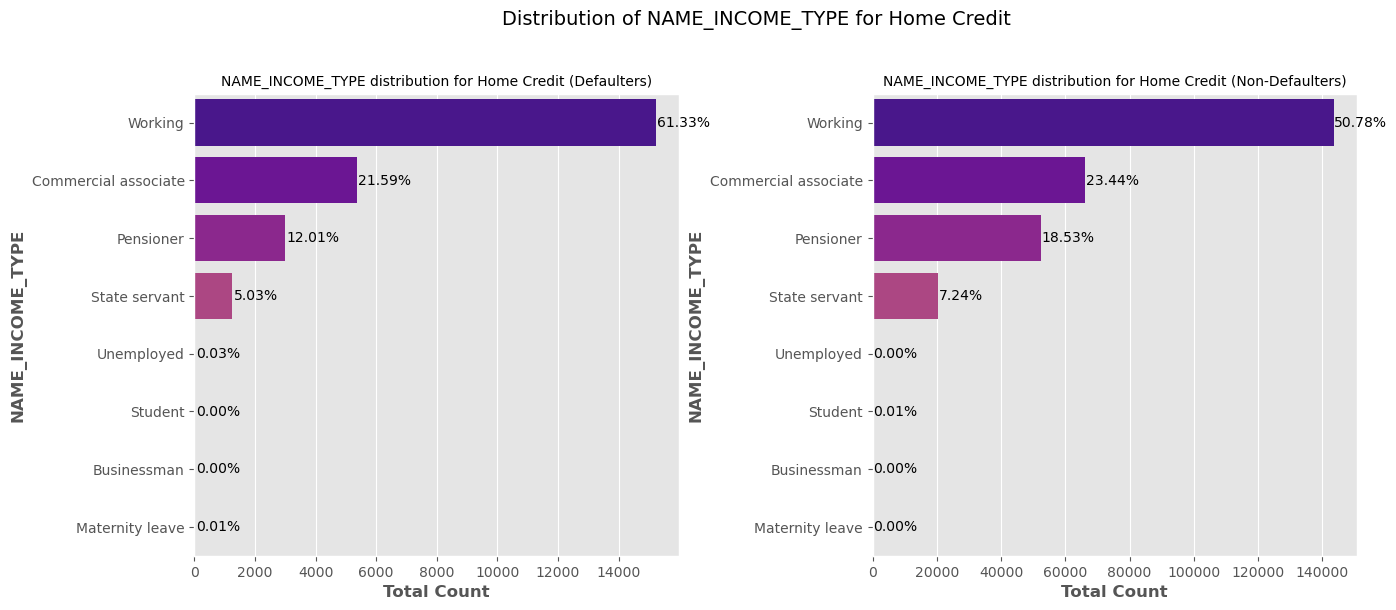

<Figure size 640x480 with 0 Axes>

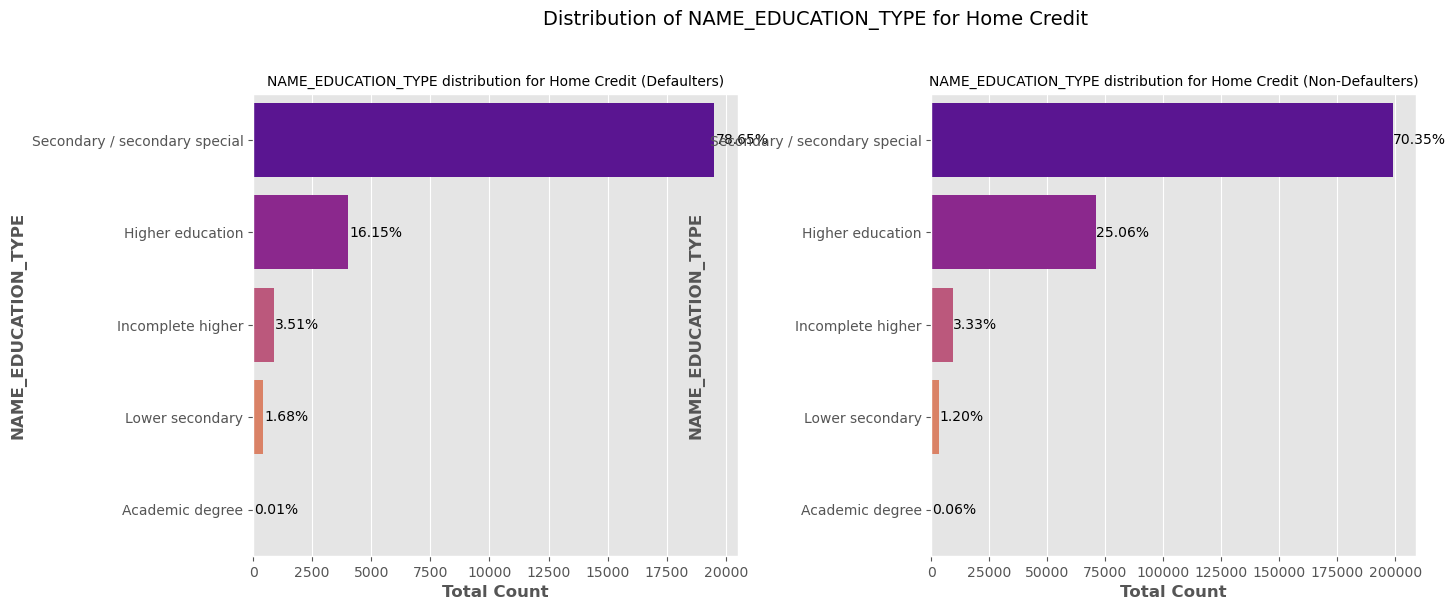

<Figure size 640x480 with 0 Axes>

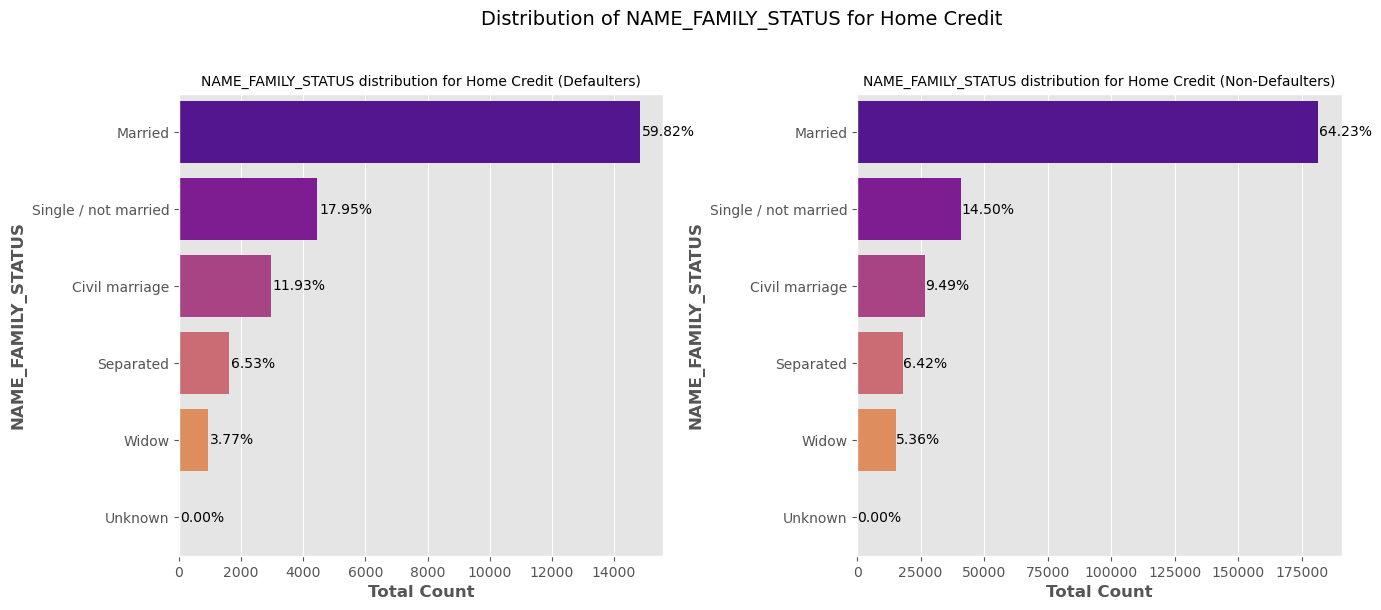

<Figure size 640x480 with 0 Axes>

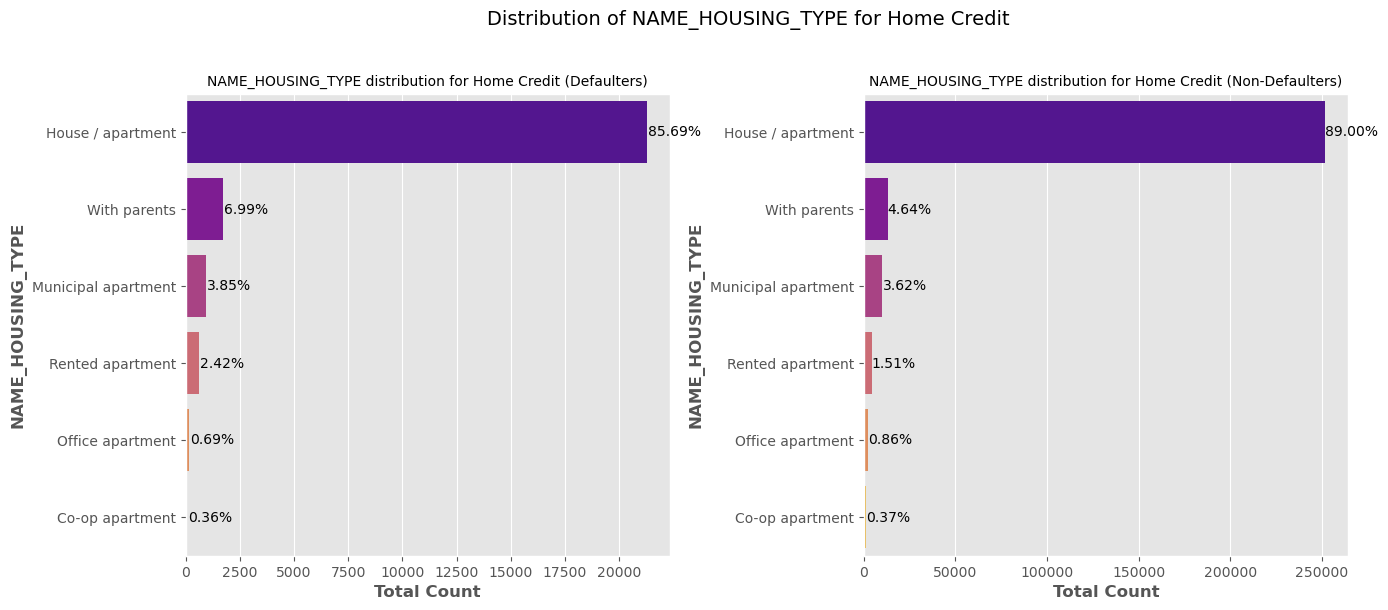

<Figure size 640x480 with 0 Axes>

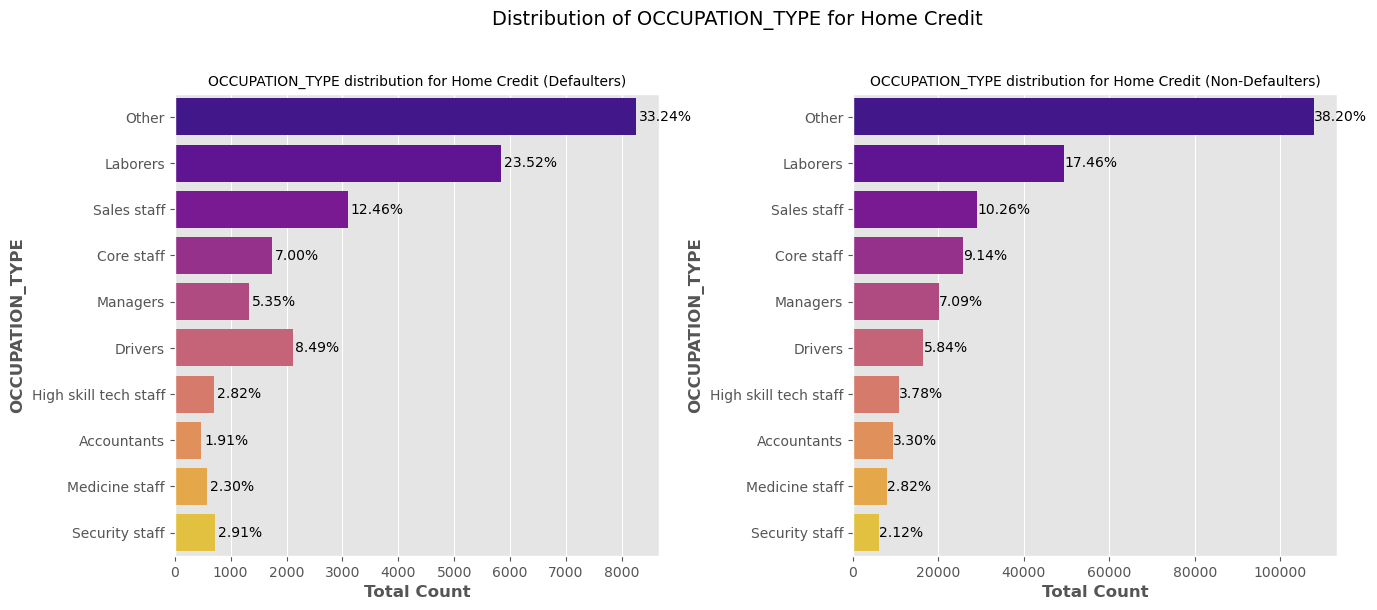

<Figure size 640x480 with 0 Axes>

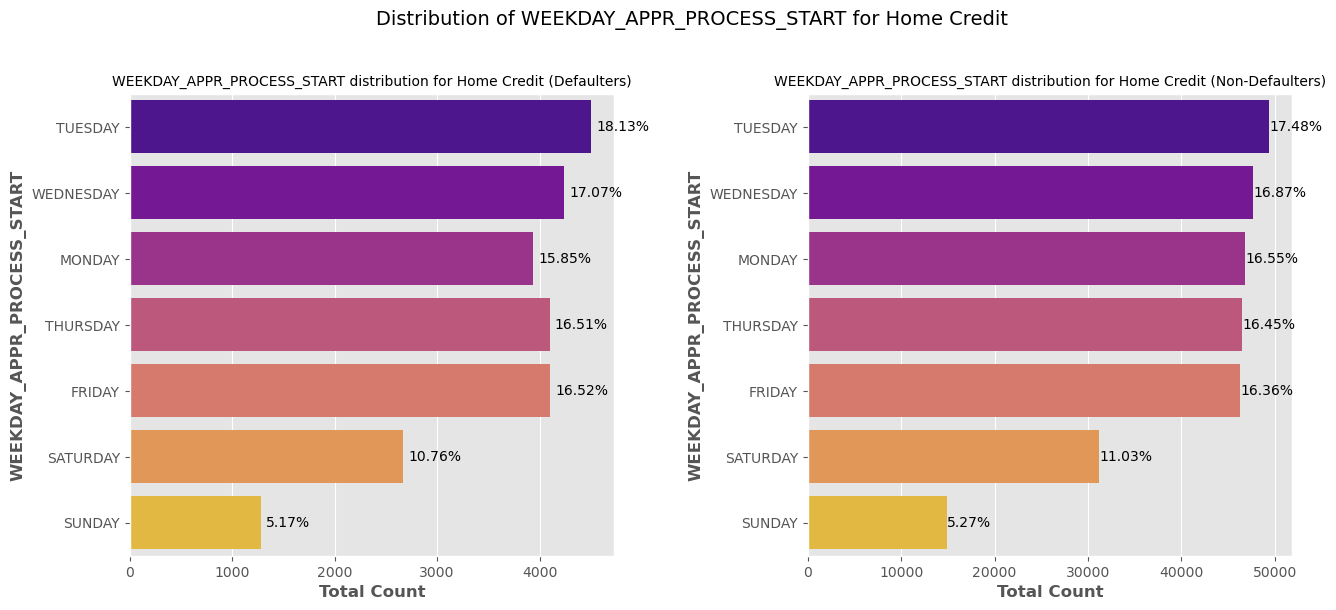

<Figure size 640x480 with 0 Axes>

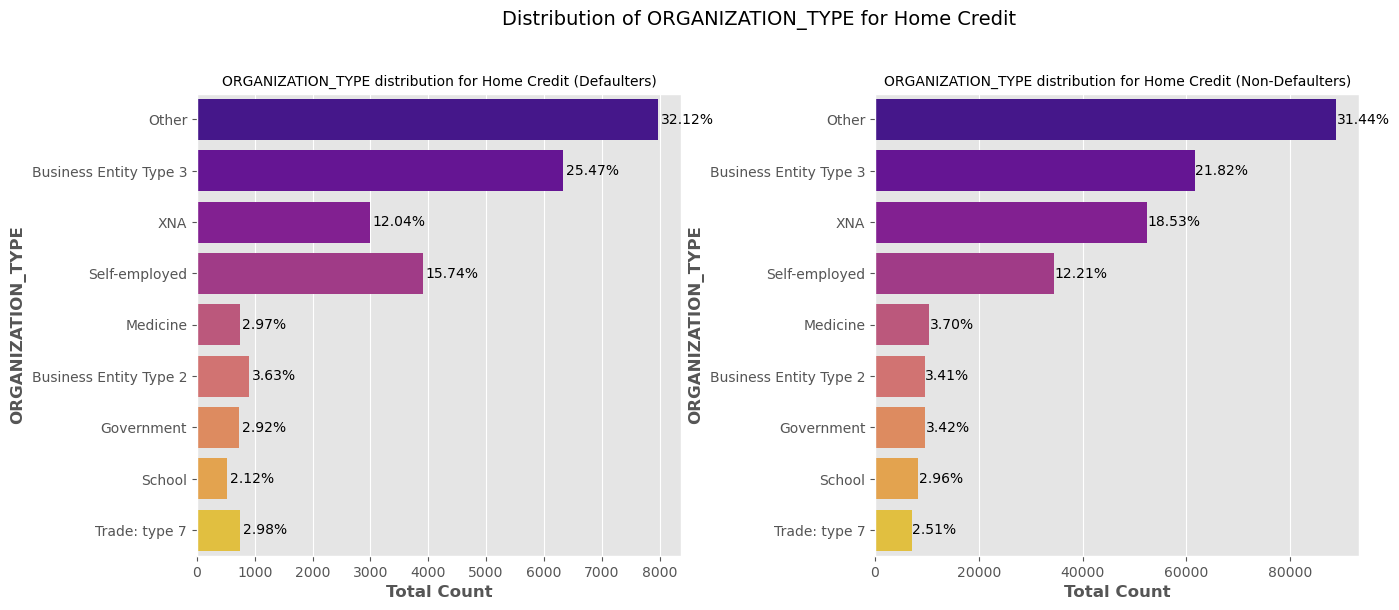

<Figure size 640x480 with 0 Axes>

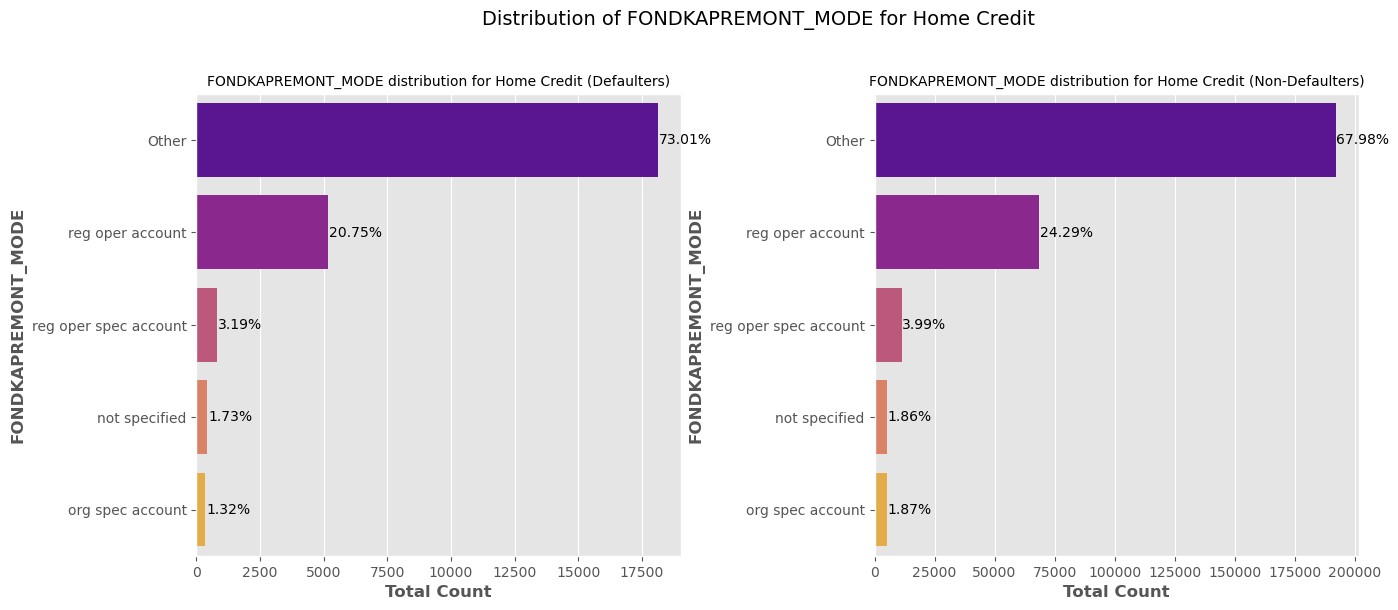

<Figure size 640x480 with 0 Axes>

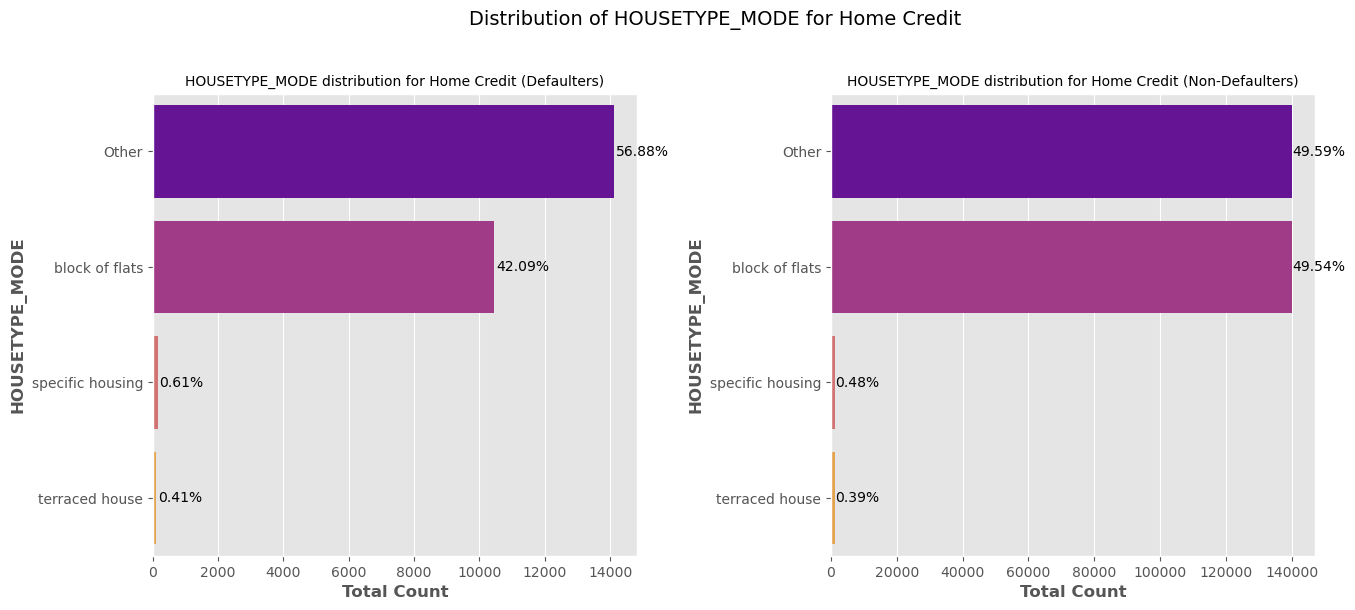

<Figure size 640x480 with 0 Axes>

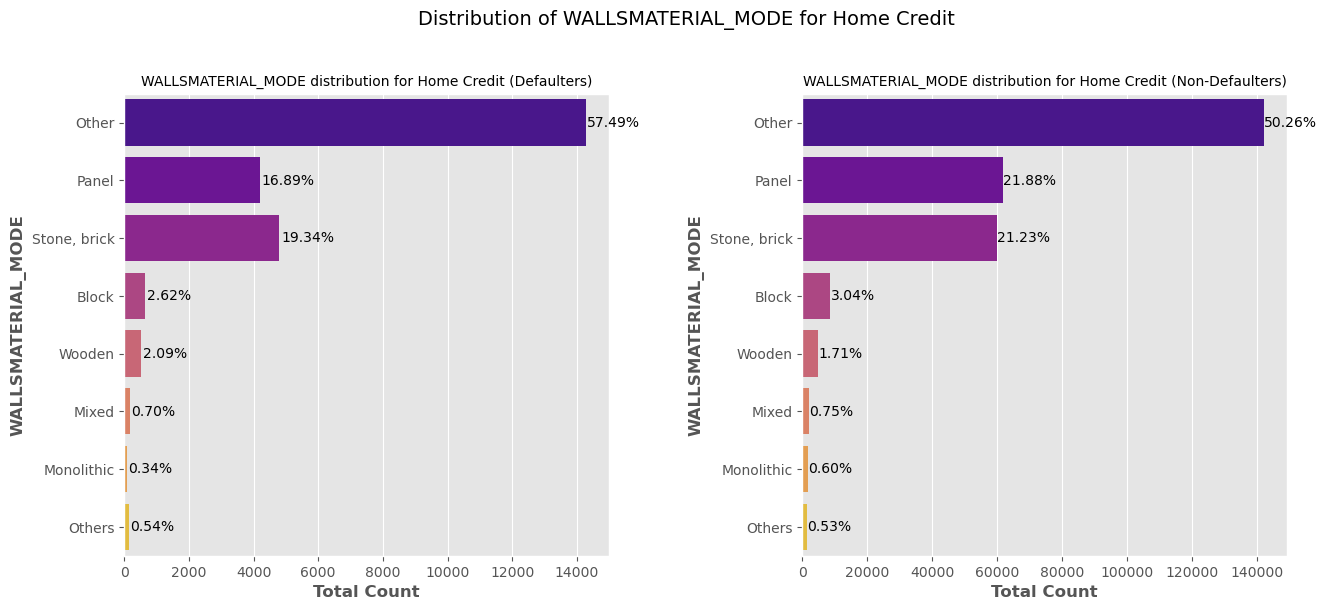

<Figure size 640x480 with 0 Axes>

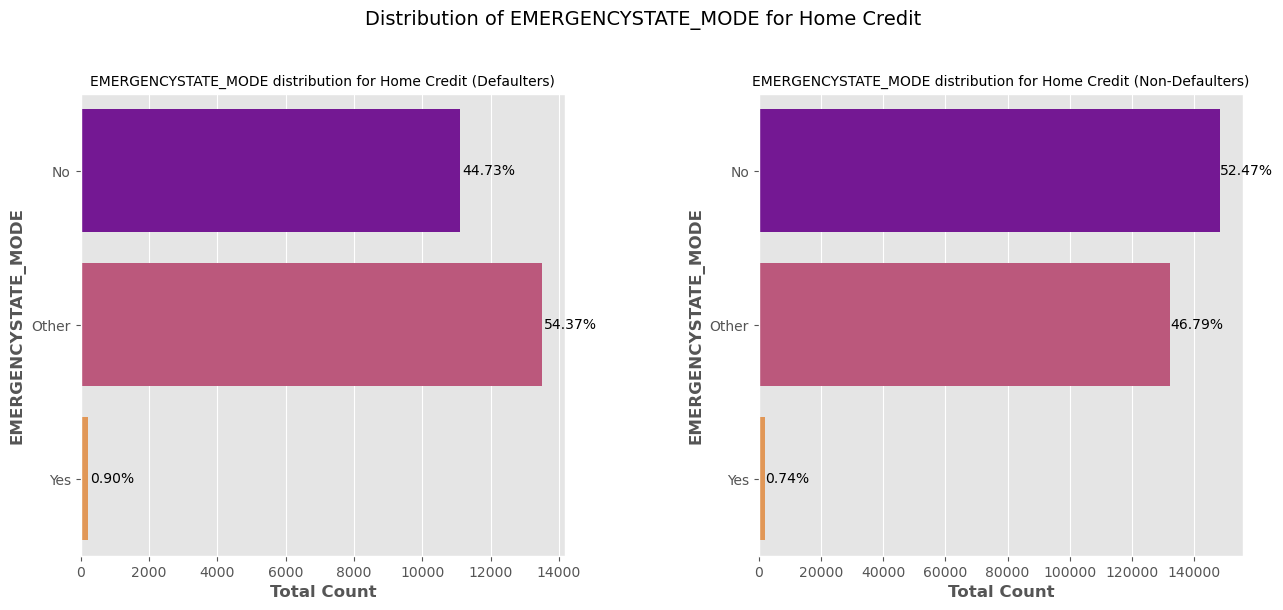

In [27]:
def cat_plot(col, target, data, top_n=9):
    plt.style.use('ggplot')
    sns.despine()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    top_categories = data[col].value_counts().index[:top_n]

    data_top_n = data.copy()
    data_top_n.loc[~data_top_n[col].isin(top_categories), col] = 'Other'

    # Subplot 1
    sns.countplot(y=col, data=data_top_n[data_top_n[target] == 0], ax=ax1, palette='plasma', order=data_top_n[col].value_counts().index)
    ax1.set_xlabel('Total Count', fontweight="bold")
    ax1.set_ylabel(f'{col}', fontweight="bold")
    ax1.set_title(f'{col} distribution for Home Credit (Defaulters)', fontsize=10)

    total_defaulters = len(data_top_n[data_top_n[target] == 0])
    for p in ax1.patches:
        ax1.annotate('{:.2f}%'.format((p.get_width() / total_defaulters) * 100),
                    (p.get_width() + 50, p.get_y() + p.get_height() / 2), va='center')

    # Subplot 2
    sns.countplot(y=col, data=data_top_n[data_top_n[target] == 1], ax=ax2, palette='plasma', order=data_top_n[col].value_counts().index)
    ax2.set_xlabel('Total Count', fontweight="bold")
    ax2.set_ylabel(f'{col}', fontweight="bold")
    ax2.set_title(f'{col} distribution for Home Credit (Non-Defaulters)', fontsize=10)

    total_non_defaulters = len(data_top_n[data_top_n[target] == 1])
    for p in ax2.patches:
        ax2.annotate('{:.2f}%'.format((p.get_width() / total_non_defaulters) * 100),
                    (p.get_width() + 50, p.get_y() + p.get_height() / 2), va='center')

    # Penyesuaian tambahan
    plt.subplots_adjust(wspace=0.4, hspace=.3)
    plt.suptitle(f'Distribution of {col} for Home Credit', fontsize=14, y=1.02)  # Tambahkan judul di bagian atas keseluruhan plot
    plt.show()

cat_cols = categorical_cols

# Melakukan plot untuk setiap kolom kategorikal
for col in cat_cols:
    cat_plot(col, "TARGET", df_train)

## Data Miining

In [28]:
# Menghapus target
non_target_attribute = data_encoded.drop(columns=['TARGET'])
frequent_itemsets = apriori(non_target_attribute, min_support=0.7, use_colnames=True, max_len=3)

frequent_itemsets

C:\ProgramData\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



support                                           itemsets
0  0.904787                    (NAME_CONTRACT_TYPE_Cash loans)
1  0.808186                    (NAME_TYPE_SUITE_Unaccompanied)
2  0.710189  (NAME_EDUCATION_TYPE_Secondary / secondary spe...
3  0.887344              (NAME_HOUSING_TYPE_House / apartment)
4  0.730189  (NAME_CONTRACT_TYPE_Cash loans, NAME_TYPE_SUIT...
5  0.804488  (NAME_HOUSING_TYPE_House / apartment, NAME_CON...
6  0.713331  (NAME_HOUSING_TYPE_House / apartment, NAME_TYP...

In [29]:
# Menemukan aturan asosiasi dengan minimum confidence 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

rules

antecedents                            consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction  zhangs_metric
0        (NAME_CONTRACT_TYPE_Cash loans)        (NAME_TYPE_SUITE_Unaccompanied)            0.904787            0.808186  0.730189    0.807028  0.998567 -0.001048    0.994000      -0.014844
1        (NAME_TYPE_SUITE_Unaccompanied)        (NAME_CONTRACT_TYPE_Cash loans)            0.808186            0.904787  0.730189    0.903491  0.998567 -0.001048    0.986570      -0.007424
2  (NAME_HOUSING_TYPE_House / apartment)        (NAME_CONTRACT_TYPE_Cash loans)            0.887344            0.904787  0.804488    0.906625  1.002031  0.001631    1.019684       0.017996
3        (NAME_CONTRACT_TYPE_Cash loans)  (NAME_HOUSING_TYPE_House / apartment)            0.904787            0.887344  0.804488    0.889146  1.002031  0.001631    1.016261       0.021293
4  (NAME_HOUSING_TYPE_House / apartment)        (NAME_TYPE_SUITE_Unaccompanied)            0.887344            0.808186  0.713331    0.803894  0.994690 -0.003808    0.978116      -0.045243
5        (NAME_TYPE_SUITE_Unaccompanied)  (NAME_HOUSING_TYPE_House / apartment)            0.808186            0.887344  0.713331    0.882632  0.994690 -0.003808    0.959854      -0.027078

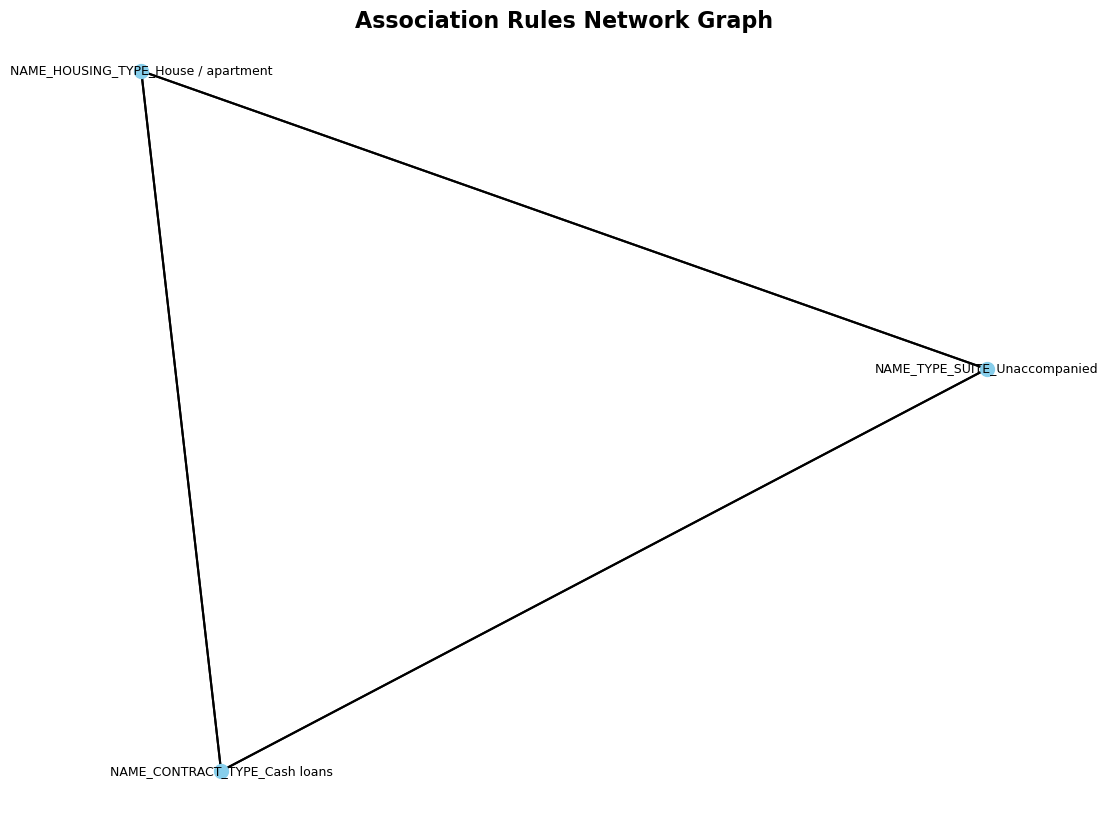

In [30]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

nodes = list(set(rules['antecedents']).union(set(rules['consequents'])))
edges = [(row['antecedents'], row['consequents']) for _, row in rules.iterrows()]

G = ig.Graph.TupleList(edges, directed=True)
layout = G.layout('fr')

fig, ax = plt.subplots(figsize=(12, 10))
for edge in G.es:
    source, target = edge.tuple
    x0, y0 = layout[source]
    x1, y1 = layout[target]
    ax.plot([x0, x1], [y0, y1], 'k-', linewidth=1.5)

for index, position in enumerate(layout):
    ax.plot(position[0], position[1], 'o', color='skyblue', markersize=10)
    if G.degree(index) > 2:
        ax.text(position[0], position[1], str(G.vs[index]['name']), fontsize=9, ha='center', va='center')

plt.title('Association Rules Network Graph', fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

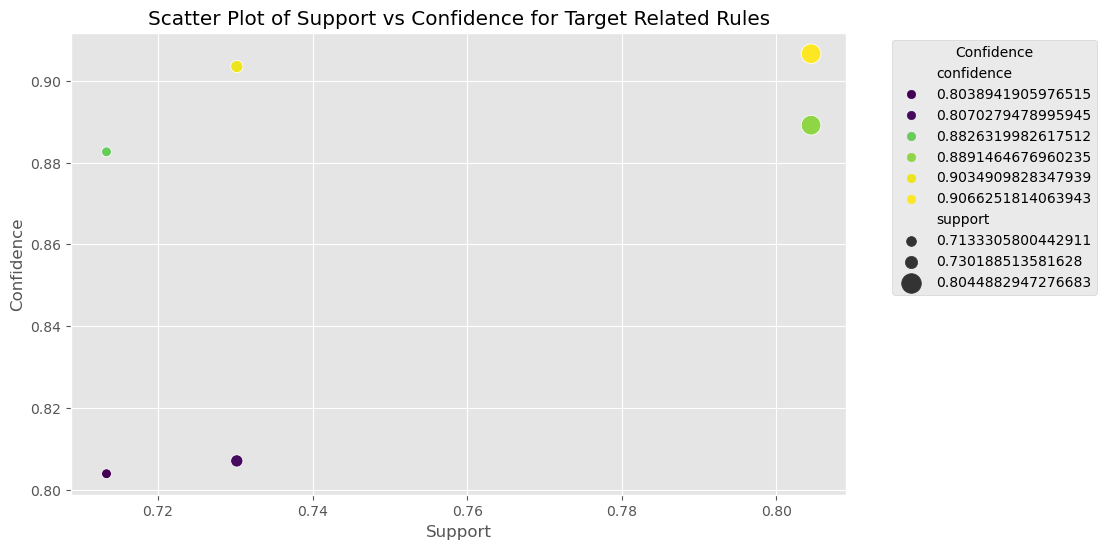

In [31]:
scatter_data = rules[['support', 'confidence']]

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='support', y='confidence', data=scatter_data, hue='confidence', palette='viridis', size='support', sizes=(50, 200))

plt.title('Scatter Plot of Support vs Confidence for Target Related Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')

plt.legend(title='Confidence', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Data Preprocessing Model Prediksi

In [32]:
application_train['TARGET'] = application_train['TARGET'].replace({0: 1, 1: 0})

In [33]:
application_train.shape

(307511, 122)

In [34]:
# Identifikasi dan Filtrasi Kolom dengan Lebih dari 60% Data Null
threshold = 0.6
columns_to_drop = missing_values[missing_values > threshold].index

columns_to_drop_existing = [col for col in columns_to_drop if col in application_train.columns]

application_train = application_train.drop(columns=columns_to_drop_existing)

print("Kolom yang dihapus:", columns_to_drop_existing)

Kolom yang dihapus: ['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE']


In [35]:
corr_matrix = application_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

application_train = application_train.drop(to_drop, axis=1)

print("Kolom yang dihapus:", to_drop)

C:\Users\USER\AppData\Local\Temp\ipykernel_16668\3742184651.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Kolom yang dihapus: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'FLAG_EMP_PHONE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'BASEMENTAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']


C:\Users\USER\AppData\Local\Temp\ipykernel_16668\1194025949.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\USER\AppData\Local\Temp\ipykernel_16668\1194025949.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

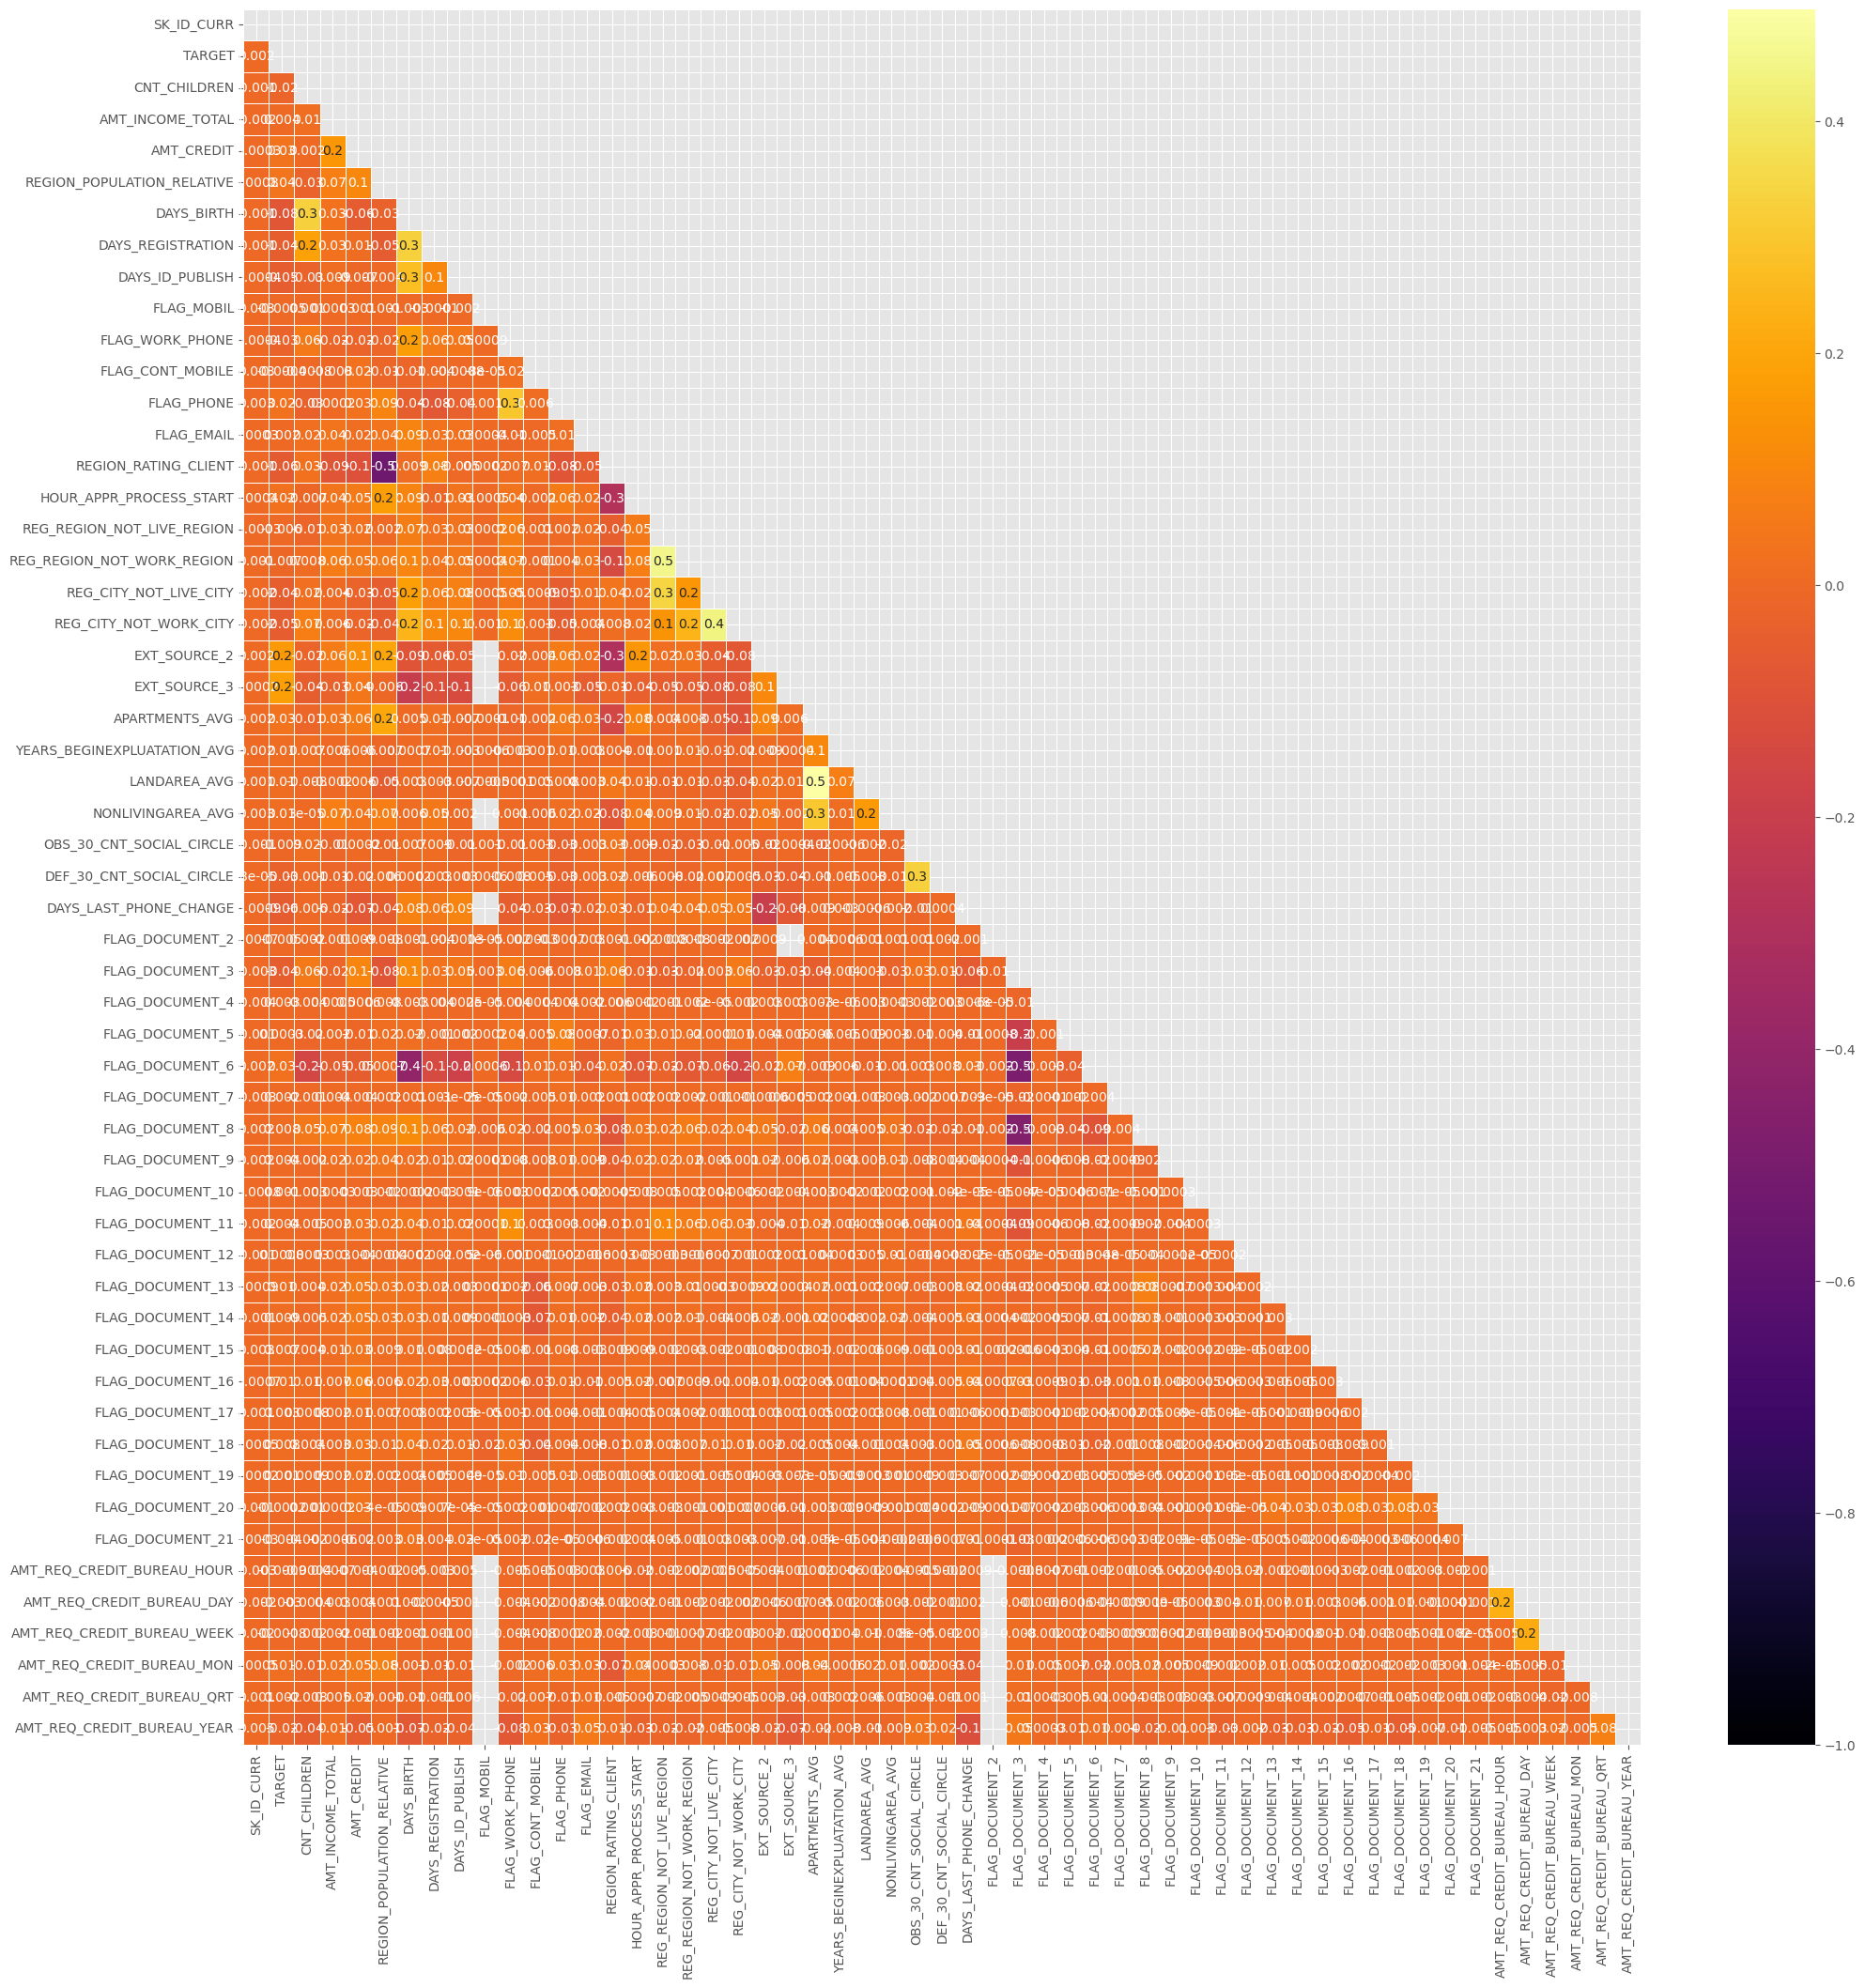

In [36]:
mask = np.zeros_like(application_train.corr().fillna(0), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(application_train.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

IV dan WoE adalah metrik yang umum digunakan dalam analisis kredit untuk menilai kekuatan prediktif variabel independen terhadap variabel target.

- *Information Value (IV):* Mengukur seberapa baik suatu variabel dapat membedakan antara dua kelas dalam variabel target. Semakin tinggi nilai IV, semakin baik variabel tersebut dalam memprediksi variabel target.

- *Weight of Evidence (WoE):* Mengukur kekuatan hubungan antara variabel independen dan variabel target. WoE menggambarkan perubahan logaritmik dalam odds antara dua kelas variabel target.

In [37]:
# Implementasikan perhitungan Information Value (IV) dan Weight of Evidence (WoE) untuk setiap variabel independen dalam dataset.
def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns
    
    # Run WoE and IV
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is : " + str(round(d['IV'].sum(),6)))
        temp = pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF = pd.concat([newDF, temp], axis=0)
        woeDF = pd.concat([woeDF, d], axis=0)

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(application_train, target='TARGET', bins=20)

Information value of SK_ID_CURR is : 0.00057
Information value of NAME_CONTRACT_TYPE is : 0.015039
Information value of CODE_GENDER is : 0.038599
Information value of FLAG_OWN_CAR is : 0.006597
Information value of FLAG_OWN_REALTY is : 0.000505
Information value of CNT_CHILDREN is : 0.001669
Information value of AMT_INCOME_TOTAL is : 0.011789
Information value of AMT_CREDIT is : 0.052786
Information value of NAME_TYPE_SUITE is : 0.001447
Information value of NAME_INCOME_TYPE is : 0.058381
Information value of NAME_EDUCATION_TYPE is : 0.050836
Information value of NAME_FAMILY_STATUS is : 0.021711
Information value of NAME_HOUSING_TYPE is : 0.01573
Information value of REGION_POPULATION_RELATIVE is : 0.045494
Information value of DAYS_BIRTH is : 0.086246
Information value of DAYS_REGISTRATION is : 0.028321
Information value of DAYS_ID_PUBLISH is : 0.039692
Information value of FLAG_MOBIL is : 2.9e-05
Information value of FLAG_WORK_PHONE is : 0.010329
Information value of FLAG_CONT_MOBILE

Aturan umum menyatakan bahwa semua variabel dengan IV < 0,02 tidak berguna untuk prediksi dan IV > 0,5 memiliki kekuatan prediksi yang mencurigakan. 

In [38]:
# Menghapus kolom dengan IV < 0.02 atau IV > 0.5
filtered_cols = iv[(iv['IV'] >= 0.02) & (iv['IV'] <= 0.5) & (iv['Variable'] != 'TARGET')]['Variable'].tolist()
filtered_cols.append('TARGET') 
application_train = application_train[filtered_cols]

# Menyaring IV yang sesuai dengan kolom yang dipertahankan
filtered_iv = iv[iv['Variable'].isin(filtered_cols)]

print("Kolom yang dihapus:", application_train.columns.difference(filtered_cols).tolist())

print("IV setelah penyaringan:")
print(filtered_iv)


Kolom yang dihapus: []
IV setelah penyaringan:
                     Variable        IV
0                 CODE_GENDER  0.038599
0                  AMT_CREDIT  0.052786
0            NAME_INCOME_TYPE  0.058381
0         NAME_EDUCATION_TYPE  0.050836
0          NAME_FAMILY_STATUS  0.021711
0  REGION_POPULATION_RELATIVE  0.045494
0                  DAYS_BIRTH  0.086246
0           DAYS_REGISTRATION  0.028321
0             DAYS_ID_PUBLISH  0.039692
0             OCCUPATION_TYPE  0.086243
0        REGION_RATING_CLIENT  0.048317
0      REG_CITY_NOT_LIVE_CITY  0.022299
0      REG_CITY_NOT_WORK_CITY  0.032207
0           ORGANIZATION_TYPE  0.073368
0                EXT_SOURCE_2  0.319257
0                EXT_SOURCE_3  0.420857
0              APARTMENTS_AVG  0.025064
0      DAYS_LAST_PHONE_CHANGE  0.047664
0             FLAG_DOCUMENT_3  0.028579


## Feature Transformation

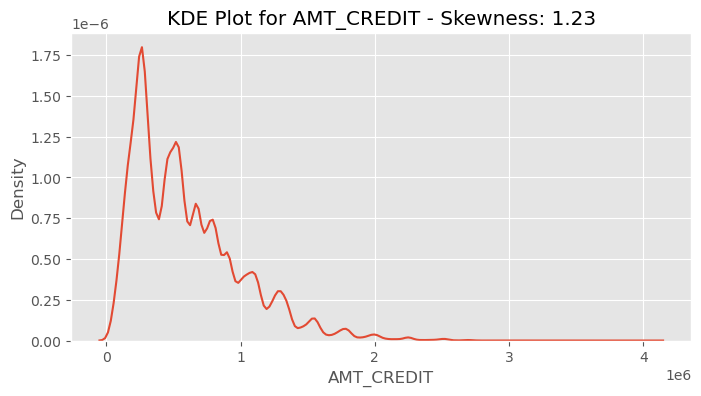

Skewness for AMT_CREDIT: 1.23


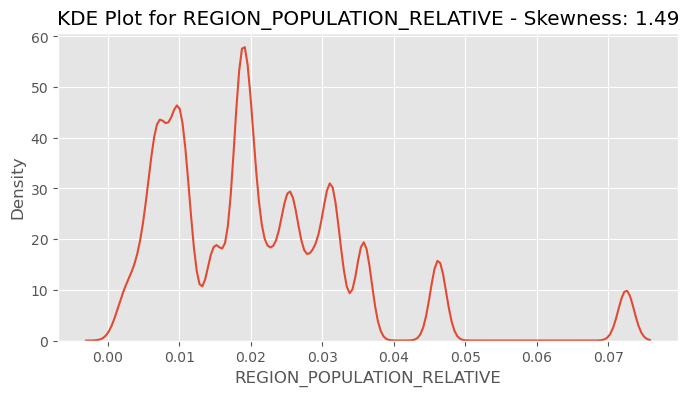

Skewness for REGION_POPULATION_RELATIVE: 1.49


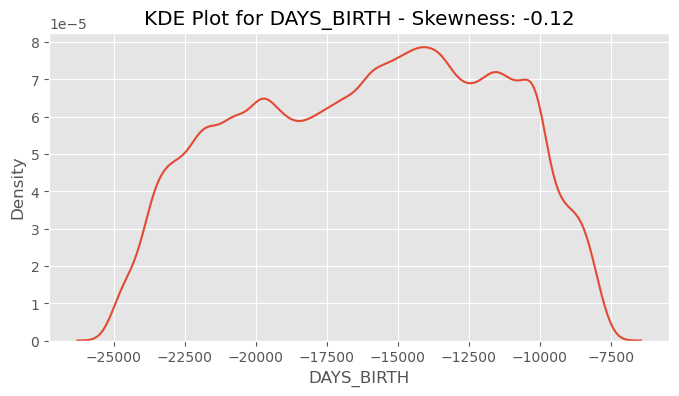

Skewness for DAYS_BIRTH: -0.12


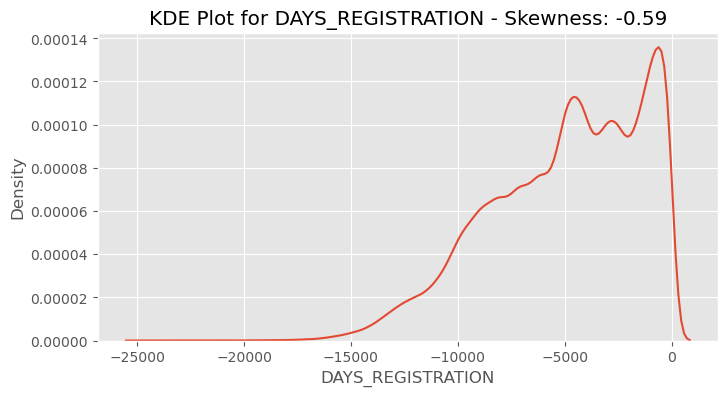

Skewness for DAYS_REGISTRATION: -0.59


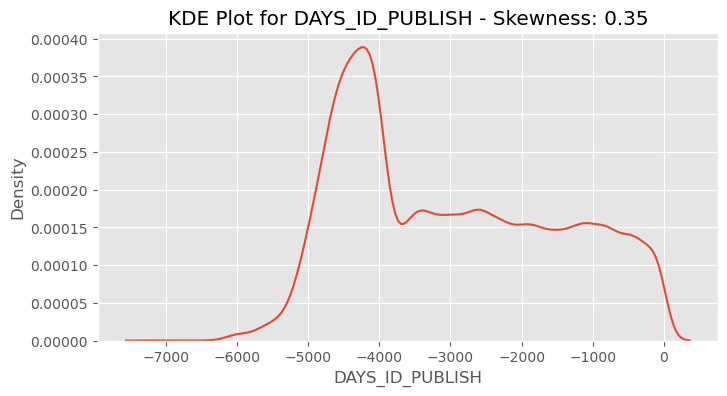

Skewness for DAYS_ID_PUBLISH: 0.35


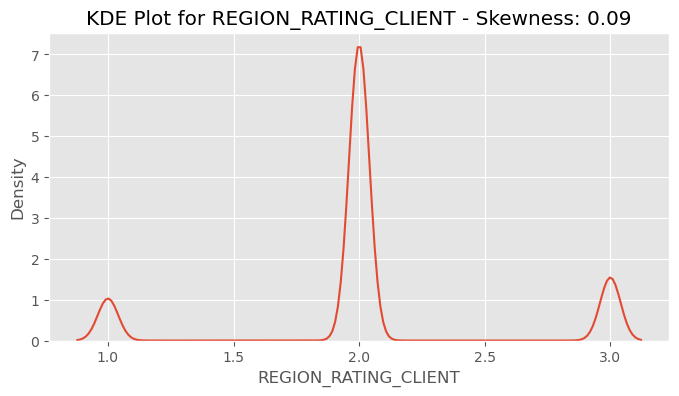

Skewness for REGION_RATING_CLIENT: 0.09


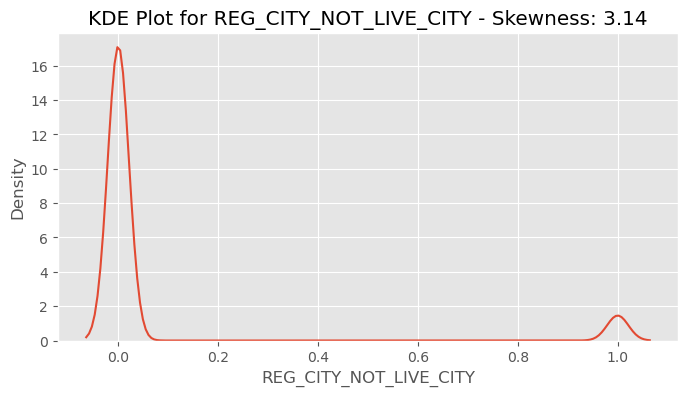

Skewness for REG_CITY_NOT_LIVE_CITY: 3.14


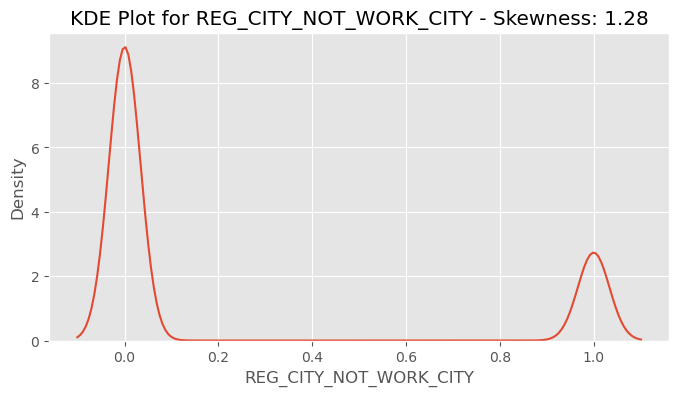

Skewness for REG_CITY_NOT_WORK_CITY: 1.28


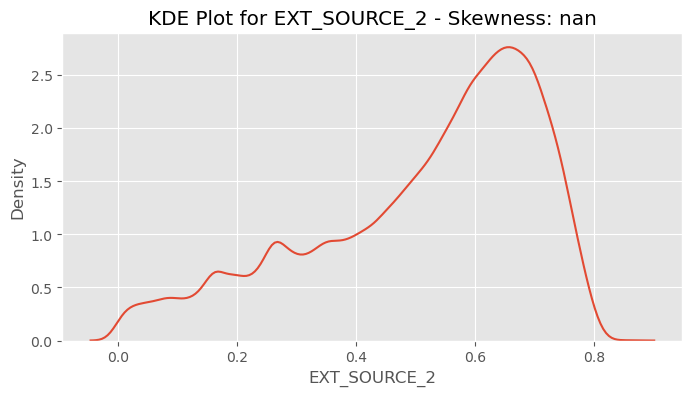

Skewness for EXT_SOURCE_2: nan


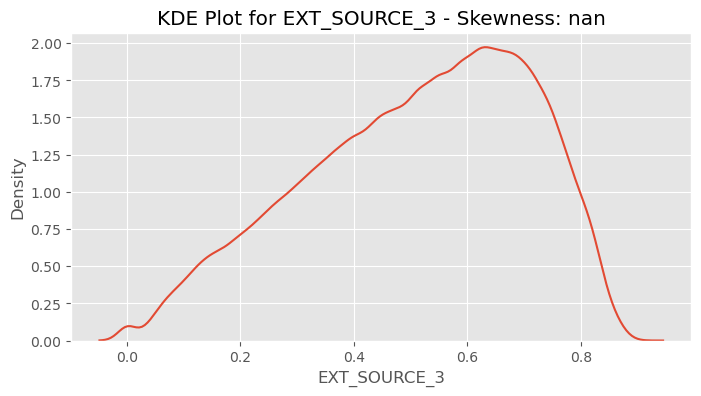

Skewness for EXT_SOURCE_3: nan


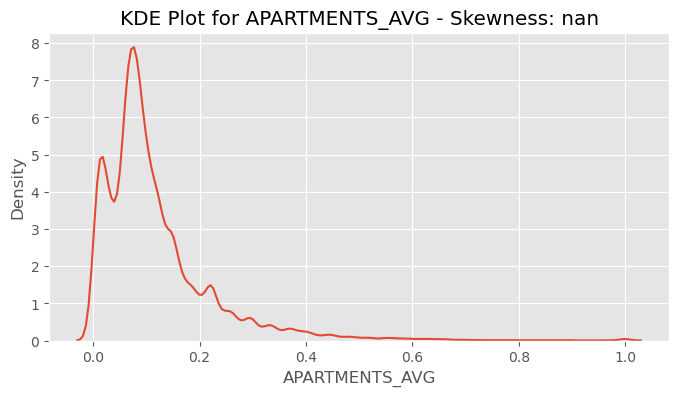

Skewness for APARTMENTS_AVG: nan


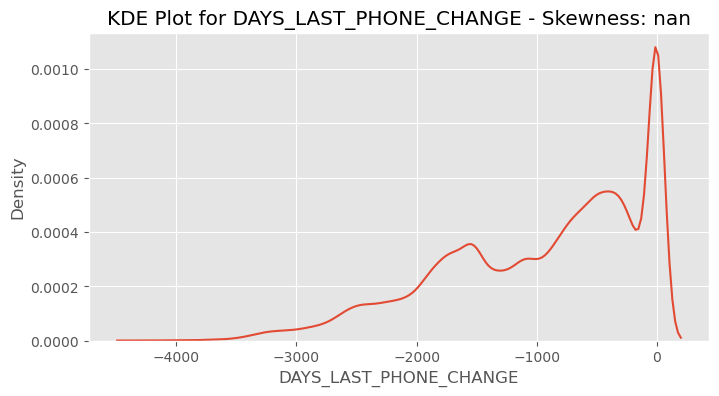

Skewness for DAYS_LAST_PHONE_CHANGE: nan


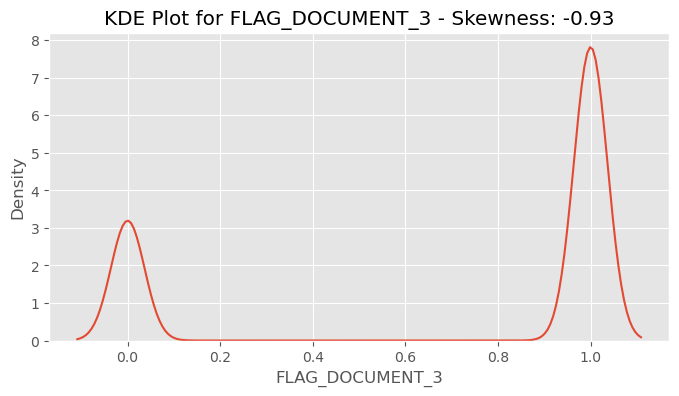

Skewness for FLAG_DOCUMENT_3: -0.93


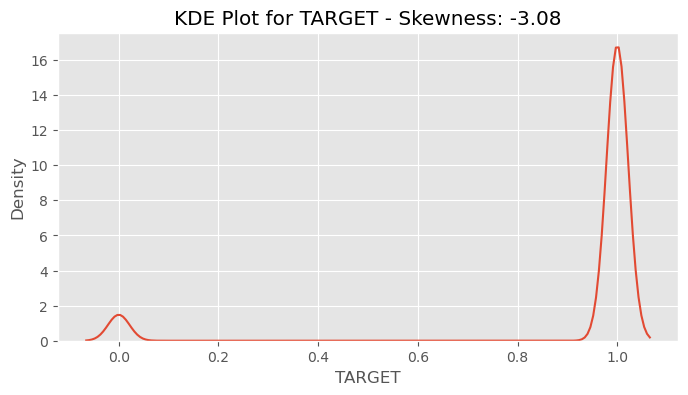

Skewness for TARGET: -3.08


In [39]:
numeric_cols = application_train.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(application_train[col])
    skewness = skew(application_train[col])
    plt.title(f'KDE Plot for {col} - Skewness: {skewness:.2f}')
    plt.show()
    print(f"Skewness for {col}: {skewness:.2f}")

### Normalization/Standarization

1. Melakukan normalisasi kolom yang memiliki distribusi skew > 0.5 atau > -0.5
2. Melakukan Standarisasi kolom yang memiliki distribusi normal antara 0.5 sampai dengan -0.5

Normalized AMT_CREDIT - Skewness: 1.23
Normalized REGION_POPULATION_RELATIVE - Skewness: 1.49
No action for DAYS_BIRTH - Skewness: -0.12
Standardized DAYS_REGISTRATION - Skewness: -0.59
No action for DAYS_ID_PUBLISH - Skewness: 0.35
No action for REGION_RATING_CLIENT - Skewness: 0.09
Normalized REG_CITY_NOT_LIVE_CITY - Skewness: 3.14
Normalized REG_CITY_NOT_WORK_CITY - Skewness: 1.28
No action for EXT_SOURCE_2 - Skewness: nan
No action for EXT_SOURCE_3 - Skewness: nan
No action for APARTMENTS_AVG - Skewness: nan
No action for DAYS_LAST_PHONE_CHANGE - Skewness: nan
Standardized FLAG_DOCUMENT_3 - Skewness: -0.93


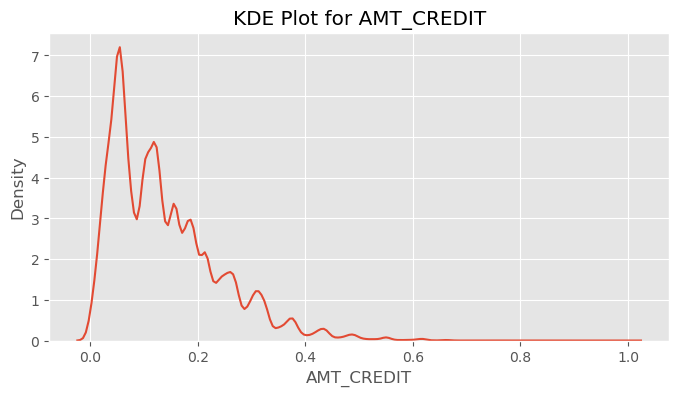

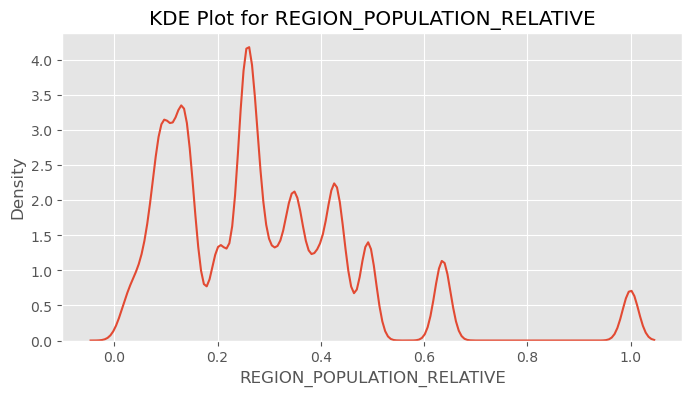

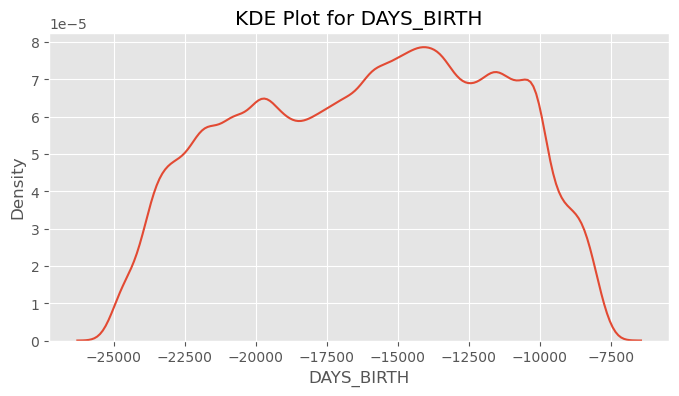

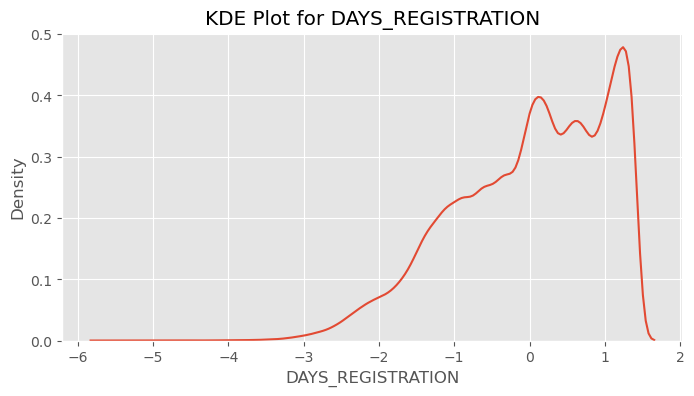

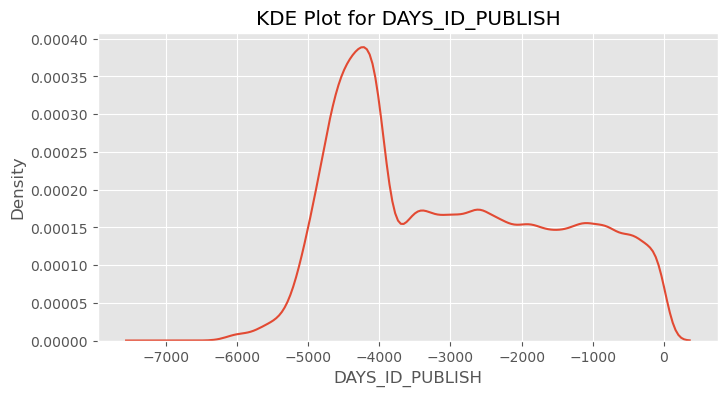

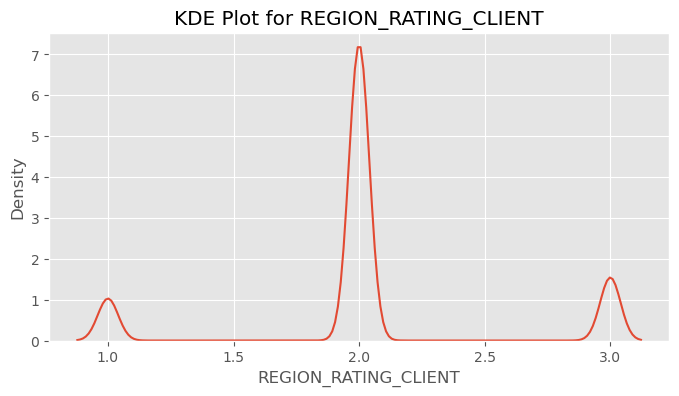

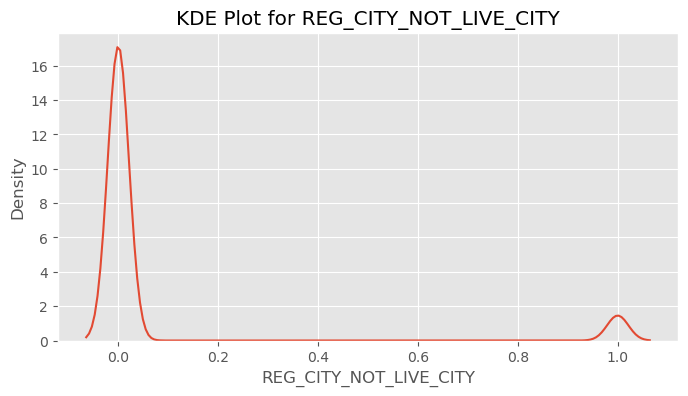

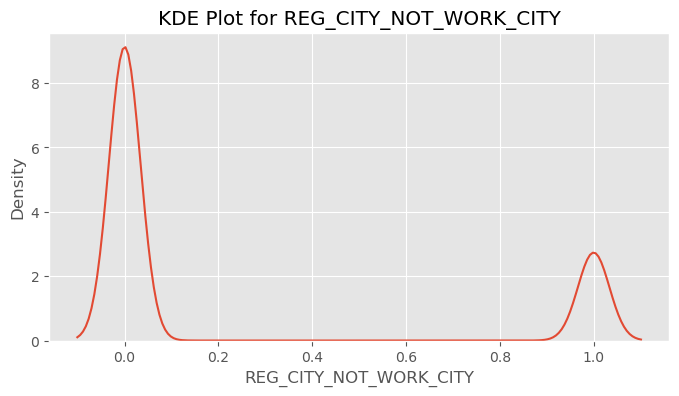

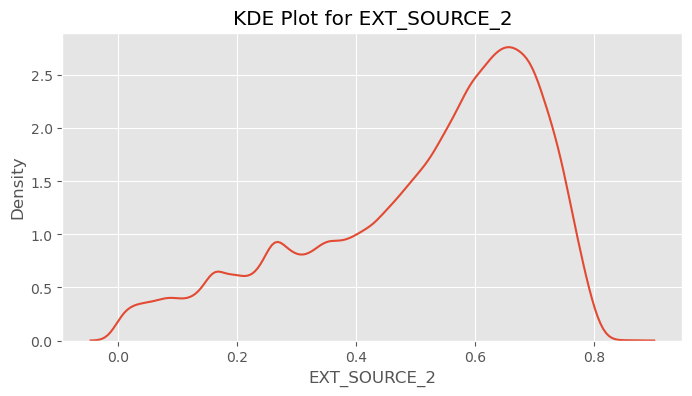

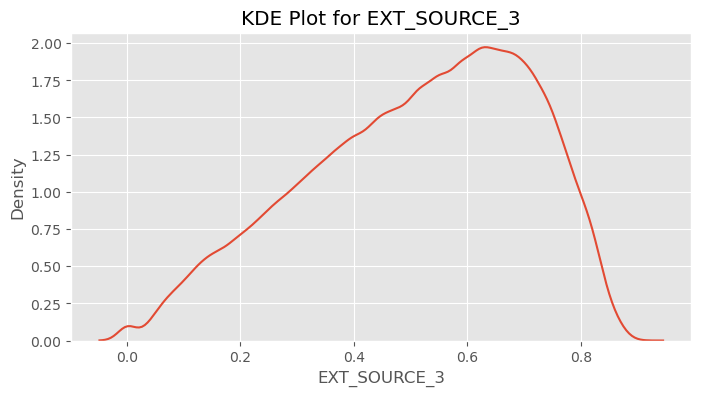

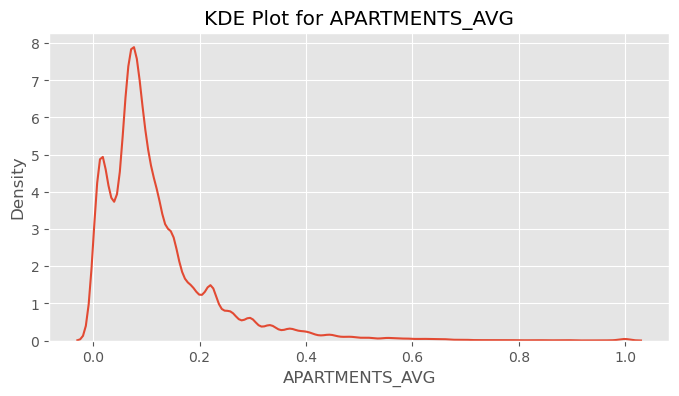

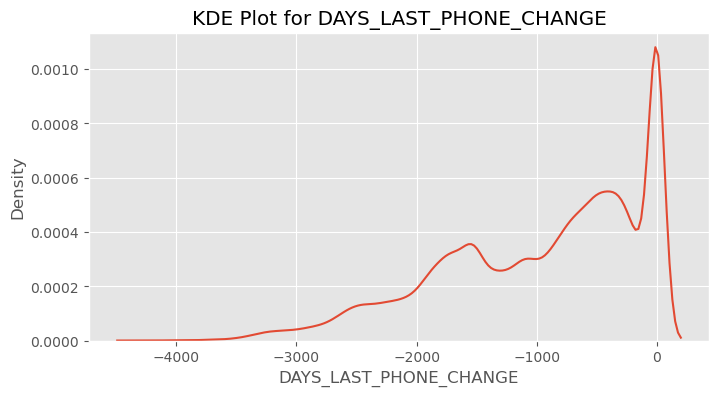

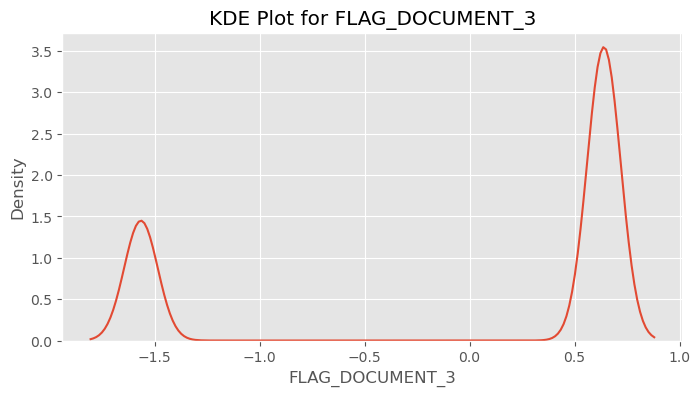

In [40]:
numeric_cols = application_train.select_dtypes(include=['float64', 'int64']).columns.drop(['TARGET'])

skewness_threshold = 0.5

for col in numeric_cols:
    skewness = skew(application_train[col])

    # Normalisasi kolom jika skewness di atas threshold
    if skewness > skewness_threshold:
        min_max_scaler = MinMaxScaler()
        application_train[col] = min_max_scaler.fit_transform(application_train[[col]])
        print(f"Normalized {col} - Skewness: {skewness:.2f}")

    # Standarisasi kolom jika skewness di bawah threshold
    elif skewness < -skewness_threshold:
        standard_scaler = StandardScaler()
        application_train[col] = standard_scaler.fit_transform(application_train[[col]])
        print(f"Standardized {col} - Skewness: {skewness:.2f}")

    # Tidak dilakukan normalisasi atau standarisasi
    else:
        print(f"No action for {col} - Skewness: {skewness:.2f}")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(application_train[col])
    plt.title(f'KDE Plot for {col}')
    plt.show()

## Feature Extraction

One-hot encoding digunakan untuk mengubah variabel kategori menjadi bentuk yang dapat diolah oleh model machine learning, dengan menggantikan variabel kategori tersebut menjadi kolom biner (0 atau 1) untuk setiap kategori yang mungkin. Ini diperlukan karena sebagian besar algoritma machine learning bekerja dengan data numerik dan tidak dapat menangani variabel kategori langsung. Dengan one-hot encoding, informasi kategori dapat diwakili secara numerik tanpa menimbulkan masalah interpretasi.

In [41]:
cat_cols = application_train.select_dtypes(include=['object']).columns

application_train = pd.get_dummies(application_train, columns=cat_cols)

In [42]:
application_train.dtypes

AMT_CREDIT                                           float64
REGION_POPULATION_RELATIVE                           float64
DAYS_BIRTH                                             int64
DAYS_REGISTRATION                                    float64
DAYS_ID_PUBLISH                                        int64
REGION_RATING_CLIENT                                   int64
REG_CITY_NOT_LIVE_CITY                               float64
REG_CITY_NOT_WORK_CITY                               float64
EXT_SOURCE_2                                         float64
EXT_SOURCE_3                                         float64
APARTMENTS_AVG                                       float64
DAYS_LAST_PHONE_CHANGE                               float64
FLAG_DOCUMENT_3                                      float64
TARGET                                                 int64
CODE_GENDER_F                                          uint8
CODE_GENDER_M                                          uint8
CODE_GENDER_XNA         

In [43]:
application_train.isnull().sum()

AMT_CREDIT                                                0
REGION_POPULATION_RELATIVE                                0
DAYS_BIRTH                                                0
DAYS_REGISTRATION                                         0
DAYS_ID_PUBLISH                                           0
REGION_RATING_CLIENT                                      0
REG_CITY_NOT_LIVE_CITY                                    0
REG_CITY_NOT_WORK_CITY                                    0
EXT_SOURCE_2                                            660
EXT_SOURCE_3                                          60965
APARTMENTS_AVG                                       156061
DAYS_LAST_PHONE_CHANGE                                    1
FLAG_DOCUMENT_3                                           0
TARGET                                                    0
CODE_GENDER_F                                             0
CODE_GENDER_M                                             0
CODE_GENDER_XNA                         

In [44]:
# Handle Missing Value untuk fitur numerkal
numeric_columns = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'DAYS_LAST_PHONE_CHANGE']
numeric_imputer = SimpleImputer(strategy='mean')
application_train[numeric_columns] = numeric_imputer.fit_transform(application_train[numeric_columns])

print(application_train.isnull().sum())

AMT_CREDIT                                           0
REGION_POPULATION_RELATIVE                           0
DAYS_BIRTH                                           0
DAYS_REGISTRATION                                    0
DAYS_ID_PUBLISH                                      0
REGION_RATING_CLIENT                                 0
REG_CITY_NOT_LIVE_CITY                               0
REG_CITY_NOT_WORK_CITY                               0
EXT_SOURCE_2                                         0
EXT_SOURCE_3                                         0
APARTMENTS_AVG                                       0
DAYS_LAST_PHONE_CHANGE                               0
FLAG_DOCUMENT_3                                      0
TARGET                                               0
CODE_GENDER_F                                        0
CODE_GENDER_M                                        0
CODE_GENDER_XNA                                      0
NAME_INCOME_TYPE_Businessman                         0
NAME_INCOM

In [45]:
application_train.shape

(307511, 112)

# Modeling

In [46]:
X = application_train.drop('TARGET', axis=1)
y = application_train['TARGET']

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((246008, 111), (61503, 111))

In [48]:
# Visualisasi distribusi default dan non-default
df_visual = application_train.TARGET.value_counts().reset_index()
df_visual.columns = ['TARGET', 'Count']

fig = px.bar(df_visual, x='TARGET', y='Count', title='Non-Defaulters (1) vs Defaulters (0)',
            labels={'Defaulters': 'Defaulters', 'Count': 'Count'},
            color='TARGET', color_discrete_map={0: 'red', 1: 'green'})
fig.show()

C:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Imbalance Handling

SMOTE, atau Synthetic Minority Over-sampling Technique, digunakan untuk menangani ketidakseimbangan kelas dalam dataset. Ketidakseimbangan kelas dapat menyebabkan model memiliki kecenderungan untuk mendiskriminasi atau mengabaikan kelas minoritas, sehingga merugikan performa model dalam memprediksi kelas tersebut.

Dari visualisasi sebelumnya dapat diketahui bahwa ada ketidakseimbangan pada class, oleh karena itu over sampling menggunakan SMOTE digunakan sehingga menyamakan distribusi kelas dan diharapkan meningkatkan performa model pada kelas minoritas tersebut.

In [49]:
# Implementasi Smote
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Data sebelum SMOTE
class_distribution_before = y_train.value_counts().reset_index()
class_distribution_before.columns = ['TARGET', 'Count']

# Data setelah SMOTE
class_distribution_after = pd.Series(y_train_resampled).value_counts().reset_index()
class_distribution_after.columns = ['TARGET', 'Count']

fig = px.bar(class_distribution_before, x='TARGET', y='Count', title='Sebelum SMOTE',
            labels={'Defaulters': 'Defaulters', 'Count': 'Jumlah Sampel'},
            color='TARGET', color_discrete_sequence=['red'])
fig.update_layout(showlegend=False)

fig2 = px.bar(class_distribution_after, x='TARGET', y='Count', title='Setelah SMOTE',
            labels={'Defaulters': 'Defaulters', 'Count': 'Jumlah Sampel'},
            color='TARGET', color_discrete_sequence=['blue'])
fig2.update_layout(showlegend=False)

fig.show()
fig2.show()

C:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



C:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [50]:
y_val.value_counts()

1    56554
0     4949
Name: TARGET, dtype: int64

In [51]:
y_train_resampled.value_counts()

1    226132
0    226132
Name: TARGET, dtype: int64

## Logistic Regression

In [52]:
# Penskalaan fitur
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)

# Implementasi PCA
pca = PCA(n_components=0.95) 
X_train_resampled_scaled_pca = pca.fit_transform(X_train_resampled_scaled)
X_val_scaled_pca = pca.transform(X_val_scaled)

model = LogisticRegression(random_state=42, solver='liblinear', C=1, penalty='l2', max_iter=1000)
model.fit(X_train_resampled_scaled_pca, y_train_resampled)
y_pred_val = model.predict(X_val_scaled_pca)

In [53]:
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_val, y_pred_val)

print("Akurasi:", accuracy)
print("Presisi:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC-ROC:", roc_auc)

Akurasi: 0.8893549908134563
Presisi: 0.9246896928514111
Recall: 0.9576687767443506
F1-Score: 0.9408903365906623
AUC-ROC: 0.5331888034055153


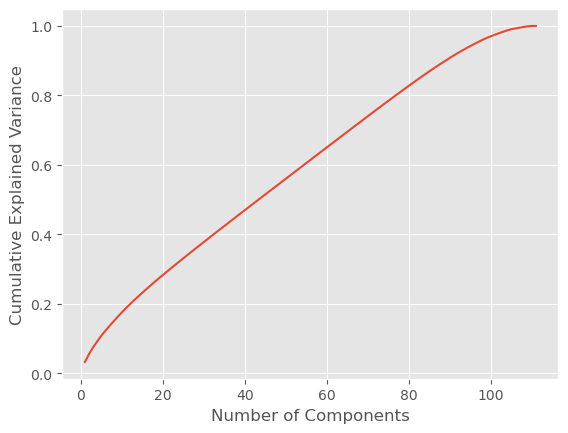

In [54]:
pca = PCA()
pca.fit(X_train_resampled_scaled)

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## LGBMClassifier

In [55]:
# Inisialisasi model LGBMClassifier
lgb_model = lgb.LGBMClassifier(random_state=42)

lgb_model.fit(X_train_resampled_scaled_pca, y_train_resampled)
y_pred_val_lgb = lgb_model.predict(X_val_scaled_pca)

# Evaluasi model pada data validasi
accuracy_lgb = accuracy_score(y_val, y_pred_val_lgb)
precision_lgb = precision_score(y_val, y_pred_val_lgb)
recall_lgb = recall_score(y_val, y_pred_val_lgb)
f1_lgb = f1_score(y_val, y_pred_val_lgb)
roc_auc_lgb = roc_auc_score(y_val, y_pred_val_lgb)

# Menampilkan hasil evaluasi
print("Akurasi (LGBMClassifier):", accuracy_lgb)
print("Presisi (LGBMClassifier):", precision_lgb)
print("Recall (LGBMClassifier):", recall_lgb)
print("F1-Score (LGBMClassifier):", f1_lgb)
print("AUC-ROC (LGBMClassifier):", roc_auc_lgb)

[LightGBM] [Info] Number of positive: 226132, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.378710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 452264, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Akurasi (LGBMClassifier): 0.9121181080597695
Presisi (LGBMClassifier): 0.9215136881314588
Recall (LGBMClassifier): 0.988630335608445
F1-Score (LGBMClassifier): 0.9538928745084323
AUC-ROC (LGBMClassifier): 0.5132078734013129
